## TODO
- Check how I calculated the feature maps, how I used the PCA. It all works, but I need to check whether I already did it according to what Micha mentioned.
- I already (most likely) did the full image regression, but the amount of principle components is immense (some are >10000). So it is likely that I did something wrong with calculating these feature maps. The results are rather bad, I have a bar plot somewhere in the notebook. This is most likely because the PCs had a percentage threshold of .8 variance retained. 
- --> To this end, check the Clip2Brain github repository.
- ------> also figure out why it's so bad, Micha said it shouldn't take more than 300 pcs to keep 90-95 variance.
- ----------> lastly figure out, using simulated data first, how to store trained pca models the most efficiently, pickle most likely, but how then to reapply them?
- The correlation between my new SCCE values don't match up with the ones I had before. Not necessarily a reason to worry, but it is a bit strange, as I was certain that the cropping went well before. It might be that I didn't change the code back properly, and it's doing something weird.
- --> The only real reason why this is important to check is because of the strange correlations with the unpredictability estimates from either (although alexnet didn't work for some reason) CNN. Also: Quite a large correlation between Spatial Coherence and Contrast Energy, which is not really supposed to be the case I think (but maybe it is? check Groen et al. another time).

- Clean all the saved files, it's a mess now. 
- Segment the separate classes in their own *.py files, saves a lot of time and scrolling.
- Figure out how to work with pycortex and pysurfer
- ----> Which freesurfer files to download?
- -------> pRF parameters, HRF fit betas (type 3)

- Clean the notebook, close other files to make everything more clear.

- Fix the colourbar in the brain plots, it is now messed up because of the forced integer indexing that I used for the layer assignment glass_brain plots, now they don't make sense anymore. There's no numbers and only half the colour map is used. 

- Verify that the novel values are scaled well.
- Check that the current predictability estimate run (pred_stack.sh) is overwriting the earlier files (most likely)

- Remake roi-based plots for delta-R with selected voxels, so the encoding (but also do the baseline feats, make a clear separation between those two types of regressions (allvoxels vs. selectvoxels)). Also run the layer assignment for this.
- Undo the changes in the layers used for feature extraction inside the U-Net class. 
- Add the imfovbeta imfovgamma colour circles to the scce_single() function, so I can verify that it's doing the right scale.
- ----> Find stereotypical images in the set that, according to Iris and Steven, should score high on SC or CE.
- --------> Then compare the old vs. the new SCCE computations.

- Work on one big integrated plot, that includes the steps for a single image, just for the presentation at Donders & own lab-meets.

- Check whether my old alexnet extracted features aren't actually good after all. I need to check for outliers, scale, zscoring, capping, etc. Because the layers are supposed to be uncorrelated (even though they weren't before), and these contain hundreds of pcs (if correctly something around 90-95% variance kept), so their individual voxel betas are supposed to be shit. I discarded them before on this basis, but I didn't know about the correlation y-y_hat R yet back then. 


# THE PROBLEM WITH THE PCA IS THAT YOU'RE NOT SUPPOSED TO RUN IT ON SEPARATE IMAGES, BUT ON A LARGE SET OF THEM, AND THEN APPLY THE TRAINED PCA TO THE OTHERS. CHANGE THIS IN THE CODE. THE CURRENT VERSION I HAVE ALREADY WORKS QUITE OK-ISH, BUT THE DIMENSIONS ARE JUST WEIRD. USE COPILOT TO FIGURE IT OUT, NOT CHATGPT BECAUSE IT IS SHIT.

In [1]:
import os
import sys
import cortex
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import copy
import yaml
import joblib

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax
from scipy.stats import zscore as zs

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from unet_recon.inpainting import UNet
from funcs.analyses import univariate_regression

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy']


##### Reload to apply class changes

In [2]:
cortex.options.usercfg

'/home/wscheurer/.config/pycortex/options.cfg'

In [23]:
def reload_nsp():
    import funcs.natspatpred
    importlib.reload(funcs.natspatpred)
    from funcs.natspatpred import NatSpatPred, VoxelSieve
    NSP = NatSpatPred()
    NSP.initialise()
    return NSP

import lgnpy.CEandSC.lgn_statistics
# from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN
import importlib
from importlib import reload
import funcs.natspatpred
import unet_recon.inpainting

importlib.reload(funcs.natspatpred)
importlib.reload(unet_recon.inpainting)
importlib.reload(lgnpy.CEandSC.lgn_statistics)

from unet_recon.inpainting import UNet
from funcs.natspatpred import NatSpatPred, VoxelSieve
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

soepstengesl


#### Load in the Naturalistic Spatial Predictions class

In [24]:
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


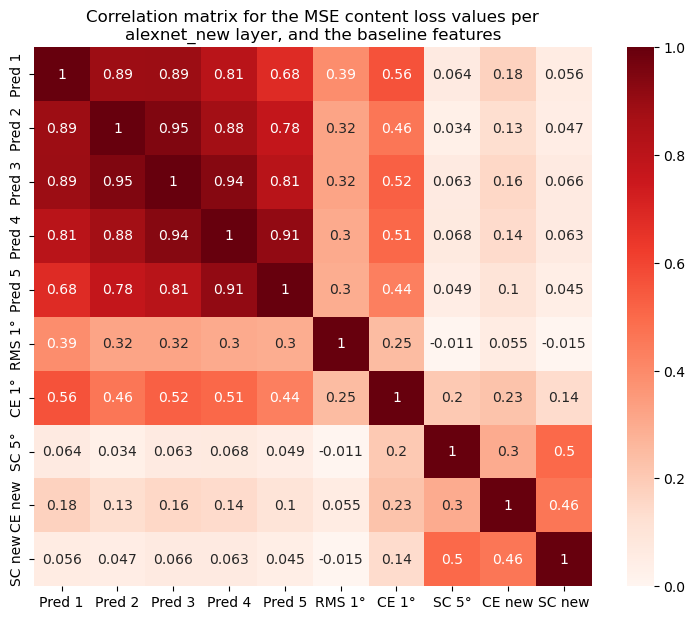

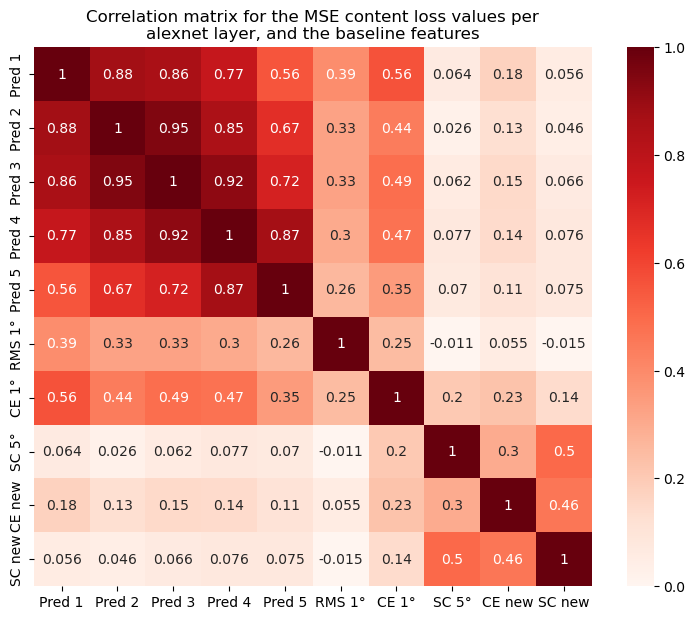

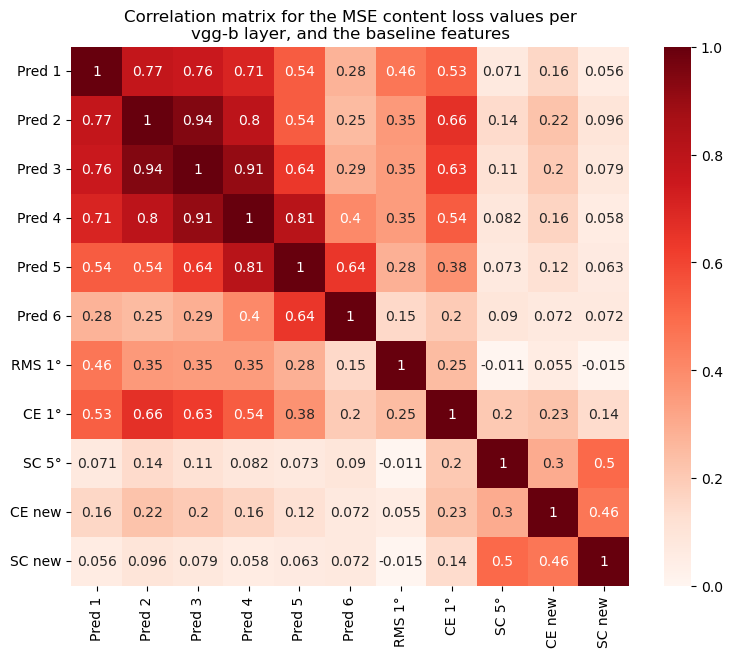

In [105]:
NSP.stimuli.plot_correlation_matrix(
    include_rms=True,
    include_ce=True,
    include_ce_l=False,
    include_sc=False,
    include_sc_l=True,
    include_sc_new=True,
    include_ce_new=True,
    cmap="Reds",
    cnn_type="alexnet_new",
    loss_calc="MSE",
)

NSP.stimuli.plot_correlation_matrix(
    include_rms=True,
    include_ce=True,
    include_ce_l=False,
    include_sc=False,
    include_sc_l=True,
    include_sc_new=True,
    include_ce_new=True,
    cmap="Reds",
    cnn_type="alexnet",
    loss_calc="MSE",
)

NSP.stimuli.plot_correlation_matrix(
    include_rms=True,
    include_ce=True,
    include_ce_l=False,
    include_sc=False,
    include_sc_l=True,
    include_sc_new=True,
    include_ce_new=True,
    cmap="Reds",
    cnn_type="vgg-b",
    loss_calc="MSE",
)

##### Load in the roi masks, and the pRF dictionary with relevant parameter data

In [6]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

Check out some pRF parameters across the visual cortex

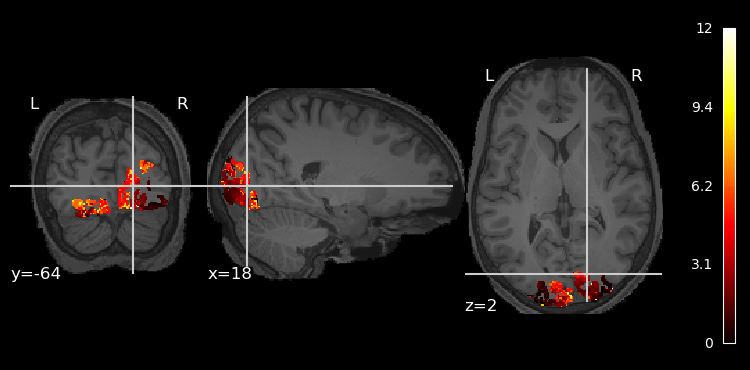

In [78]:
ecc_across_cortex = NSP.utils.cap_values(
    np.nan_to_num(prf_dict["subj01"]["nsd_dat"]["eccentricity"]["prf_ar"]), 0, 12.5
) * viscortex_mask.astype(bool)

NSP.analyse.plot_brain(
    prf_dict,
    roi_masks,
    "subj01",
    ecc_across_cortex,
    cmap=NSP.utils.duplicate_cmap("hot"),  # Needed for the colourmap to work
    glass_brain=False,
)

##### Define central aggregate pRF patch requirements
and
##### Build a dictionary with VoxelSieve class instances for each region of interest containing voxels that fulfill these requirements.

V1 voxels that fulfill requirements: 186 out of 7887.
V2 voxels that fulfill requirements: 287 out of 8296.
V3 voxels that fulfill requirements: 421 out of 7022.
V4 voxels that fulfill requirements: 223 out of 3976.

Class contains the following attributes:
 .angle
 .central_patch
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


Patch centre at y: 213, and x:213


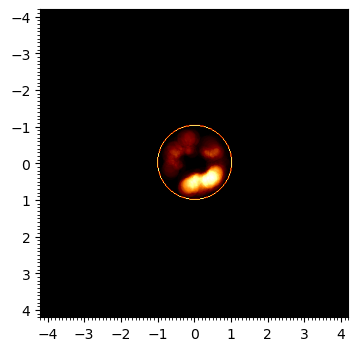

In [7]:
subject = "subj01"
max_size = 2
min_size = 0.1
patchbound = 1
min_nsd_R2 = 50
min_prf_R2 = 0
equal_voxel_numbers = False

voxeldict = {}
n_voxels = []
for roi in rois:
    print_attr = True if roi == rois[len(rois) - 1] else False
    voxeldict[roi] = VoxelSieve(
        NSP,
        prf_dict,
        roi_masks,
        subject=subject,
        roi=roi,
        patchloc="central",
        max_size=max_size,
        min_size=min_size,
        patchbound=patchbound,
        min_nsd_R2=min_nsd_R2,
        min_prf_R2=min_prf_R2,
        print_attributes=print_attr,
        fixed_n_voxels=None,
    )
    n_voxels.append(len(voxeldict[roi].size))

max_n_voxels = np.min(n_voxels)
if equal_voxel_numbers:
    # Limit the number of voxels based on the lowest number of available voxels across rois
    for roi in rois:
        voxeldict[roi].vox_lim(max_n_voxels)
        print(f"{roi} voxels capped at: {max_n_voxels}")

NSP.cortex.plot_prfs(
    voxeldict["V1"], enlarge=False, which_voxels="all", cmap="afmhot"
)  # Plot the summed pRFs

##### All voxels from V1, V2, V3, and V4

In [ ]:
subject = 'subj01'
voxeldict = {}
for roi in rois:
    print_attr = True if roi == rois[len(rois)-1] else False
    voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                subject=subject, 
                                roi=roi,
                                print_attributes=print_attr,
                                fixed_n_voxels='all')
    
NSP.cortex.plot_prfs(voxeldict['V1'], enlarge=False, which_voxels='all', cmap='afmhot')

##### Define peripheral aggregate pRF patch requirements

In [120]:
# Double check whether the peripheral patches are fully vectorised, they take some time still (not much though)

subject = "subj01"
max_size = 3
min_size = 0.25
patchbound = 1
min_nsd_R2 = 0
min_prf_R2 = 0
# peripheral_center = (-2, 2)
peri_angle = 270
peri_ecc = 3
# fixed_n_voxels = 50

voxeldict = {}
for roi in rois:
    print_attr = True if roi == rois[len(rois) - 1] else False
    voxeldict[roi] = VoxelSieve(
        NSP,
        prf_dict,
        roi_masks,
        subject=subject,
        roi=roi,
        patchloc="peripheral",
        max_size=max_size,
        min_size=min_size,
        patchbound=patchbound,
        min_nsd_R2=min_nsd_R2,
        min_prf_R2=min_prf_R2,
        print_attributes=print_attr,
        fixed_n_voxels=10,
        peripheral_center=None,
        peri_angle=peri_angle,
        peri_ecc=peri_ecc,
    )

Peripheral center at (-0.0, -3.0)
Patch localisation triangle with side lengths o: 3.0, a: 0.0, s: 3.0
ecc_min: 2.0, ecc_max: 4.0
Peripheral patch at angle 270.0 with boundary angles at min: 251.57, max: 288.43
V1 voxels that fulfill requirements: 10 out of 7887.
Peripheral center at (-0.0, -3.0)
Patch localisation triangle with side lengths o: 3.0, a: 0.0, s: 3.0
ecc_min: 2.0, ecc_max: 4.0
Peripheral patch at angle 270.0 with boundary angles at min: 251.57, max: 288.43
V2 voxels that fulfill requirements: 10 out of 8296.
Peripheral center at (-0.0, -3.0)
Patch localisation triangle with side lengths o: 3.0, a: 0.0, s: 3.0
ecc_min: 2.0, ecc_max: 4.0
Peripheral patch at angle 270.0 with boundary angles at min: 251.57, max: 288.43
V3 voxels that fulfill requirements: 10 out of 7022.
Peripheral center at (-0.0, -3.0)
Patch localisation triangle with side lengths o: 3.0, a: 0.0, s: 3.0
ecc_min: 2.0, ecc_max: 4.0
Peripheral patch at angle 270.0 with boundary angles at min: 251.57, max: 288.

##### Visualise the pRFs

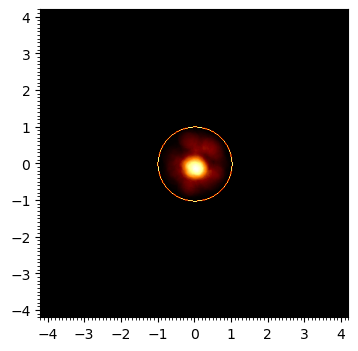

In [207]:
NSP.cortex.plot_prfs(voxeldict["V1"], enlarge=False, which_voxels="all", cmap="afmhot")

##### Load in the HRF signal betas for the selected voxels

In [79]:
ydict = {}
for roi in rois:
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials='all').T
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')

V1 y-matrix has dimensions: (30000, 186)
V2 y-matrix has dimensions: (30000, 287)
V3 y-matrix has dimensions: (30000, 421)
V4 y-matrix has dimensions: (30000, 223)


In [7]:
ydict = {}
for roi in rois:
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=10000).T
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')

V1 y-matrix has dimensions: (10000, 186)
V2 y-matrix has dimensions: (10000, 287)
V3 y-matrix has dimensions: (10000, 421)
V4 y-matrix has dimensions: (10000, 223)


##### Inspect some individual pRFs with corresponding parameter values

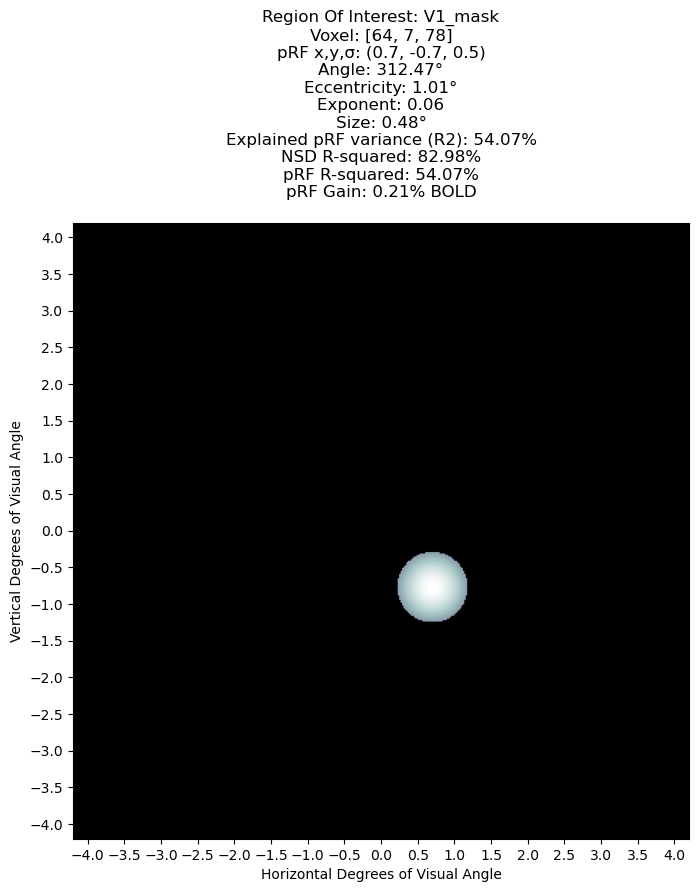

In [110]:
roi = 'V1'
randomvox = random.randint(0, voxeldict[roi].xyz.shape[0])
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        subject=subject,
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=voxeldict[roi].xyz[randomvox])

## Acquire the baseline visual contrast and estimated unpredictability values of the naturalistic images

##### Load in one of the baseline features (Root Mean Square, Spatial Coherence, Contrast Energy)

In [135]:
# OUTDATED ONES. But keep them for a bit, because the differences
# between the new ones are a bit weird. Septuple check whether the
# newest ones are correct. Go through the lgnpy class some more time. 

outbound = 0.3
Xrms = NSP.stimuli.baseline_feats(subject, "rms", outlier_bound=outbound)
Xce = NSP.stimuli.baseline_feats(subject, "ce", outlier_bound=outbound)
Xsc = NSP.stimuli.baseline_feats(
    subject, "sc_l", outlier_bound=outbound
)  # the _l attachment is for 'large' -> computed feature for 5° radius patch

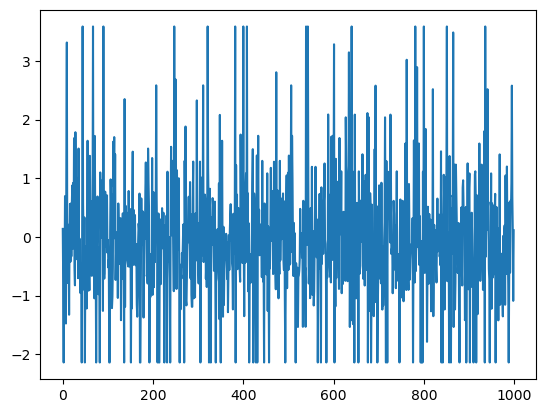

In [20]:
plt.plot(sc.values[:1000])

In [80]:
subject = "subj01"
rms = NSP.stimuli.get_rms(
    subject, rel_or_irrel="rel", crop_prior=True, outlier_bound=0.3
)
sc = NSP.stimuli.get_scce(subject, "sc")
ce = NSP.stimuli.get_scce(subject, "ce")
baseline = pd.concat([rms, sc, ce], axis=1)

NSP.utils.inspect_dat(rms)
print("\n")
NSP.utils.inspect_dat(ce)
print("\n")
NSP.utils.inspect_dat(sc)

Lowest value: -2.3783410337921045
Highest value: 4.639860110335589
Mean value: 7.579122514774402e-18
Standard deviation: rms    1.0
dtype: float64


Lowest value: -1.0321494454703553
Highest value: 5.146262823623744
Mean value: -0.0011627562730258422
Standard deviation: ce    1.010722
dtype: float64


Lowest value: -2.1396776050486404
Highest value: 3.588718572137364
Mean value: -0.007298071057917586
Standard deviation: sc    1.000356
dtype: float64


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Example of the Root Mean Square visual contrasts

Processing image number: 0 out of 2


NameError: name 'scce_single' is not defined

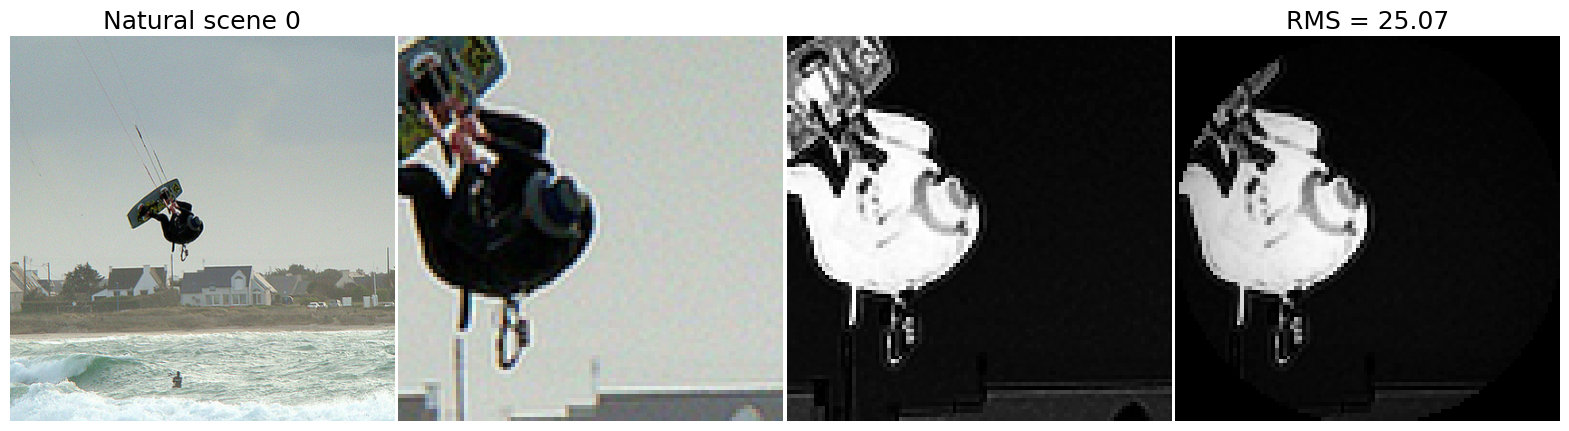

In [81]:
import random
scene = random.randint(0,72999)
_ = NSP.stimuli.rms_single(args=(0, 1, 1, False, True, 'center', True, False, False),
                       ecc_max=1,
                       cmap='Greys_r',
                       normalise=True,
                       lab_idx=0)

a = scce_single((0, 0, 1, 'y', 'center', False, False, False), ecc_max = 1, cmap = 'Greys_r') 
print(a)

### TODO: Implement this preview in NSP, and think about what makes sense to show. Quickly look up the computations for SC and CE in the LGN class, and add the OG img and crop to the current plot. MAke sure that it's clear what you're seeing in the plot. 

### But, don't put in too much effort because not at all crucial. Do make sure it's the same image as the one for RMS, helps make things clear

In [5]:
import yaml
import lgnpy.CEandSC.lgn_statistics
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

In [ ]:
config_path = '/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/default_config.yml'

with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.UnsafeLoader)

lgn = LGN(config=config, default_config_path=config_path)

threshold_lgn = loadmat(filepath='/home/rfpred/notebooks/alien_nbs/lgnpy/ThresholdLGN.mat')['ThresholdLGN']

In [40]:
# Function that calculates rms but based on a RGB to LAB conversion, which follows the CIELAB colour space
# This aligns best with the way humans perceive visual input. 
def get_scce_contrast(rgb_image, mask_w_in, rf_mask_in, full_array, plot = 'n', cmap = 'gist_gray', 
                      crop_prior:bool = False, crop_post:bool = False, save_plot:bool = False):

    lgn_out = lgn_statistics(im=rgb_image, file_name='noname.tiff',
                                        config=config, force_recompute=True, cache=False,
                                        home_path='./notebooks/alien_nbs/', verbose = False, verbose_filename=False,
                                        threshold_lgn=threshold_lgn, compute_extra_statistics=False,
                                        crop_prior = True)
    
    ce = np.mean(lgn_out[0][:, :, 0])
    sc = np.mean(lgn_out[1][:, :, 0])
    beta = np.mean(lgn_out[2][:, :, 0])
    gamma = np.mean(lgn_out[3][:, :, 0])
    
    if plot == 'y':
        fig,axs = plt.subplots(2,3, figsize=(15,10))
        plt.subplots_adjust(wspace=.01, hspace=.01)
        axs[0,0].imshow(lgn_out[4]['par1'], cmap=cmap)
        axs[0,0].axis('off')
        axs[0,1].imshow(lgn_out[4]['par2'], cmap=cmap)
        axs[0,1].axis('off')
        axs[0,2].imshow(lgn_out[4]['par3'], cmap=cmap)
        axs[0,2].axis('off')
        axs[1,0].imshow(lgn_out[4]['mag1'], cmap=cmap)
        axs[1,0].axis('off')
        axs[1,1].imshow(lgn_out[4]['mag2'], cmap=cmap)
        axs[1,1].axis('off')
        axs[1,2].imshow(lgn_out[4]['mag3'], cmap=cmap)
        axs[1,2].axis('off')
        plt.tight_layout()

        if save_plot:
            fig.savefig(f'rms_crop_prior_{str(crop_prior)}_crop_post_{str(crop_post)}.png')
            
    return ce, sc, beta, gamma

def scce_single(args, ecc_max = 2.8, loc = 'center', plot = 'n', cmap = 'gist_gray'):
    i, start, n, plot, loc, crop_prior, crop_post, save_plot  = args
    dim = NSP.stimuli.show_stim(hide=True)[0].shape[0]
    radius = ecc_max * (dim / 8.4)
    
    if loc == 'center':
        x = y = (dim + 1)/2
    elif loc == 'irrelevant_patch':
        x = y = radius + 10
        
    mask_w_in = NSP.utils.css_gaussian_cut(dim, x, y, radius).reshape((425,425))
    rf_mask_in = NSP.utils.make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    full_ar_in = ar_in = NSP.stimuli.show_stim(img_no=i, hide=True)[0]  
    
    if i % 100 == 0:
        print(f"Processing image number: {i} out of {n + start}")
        
        
    # Crop the image first, then provide this as input to the visfeat function
    if crop_prior:
        
        x_min, x_max, y_min, y_max = NSP.utils.get_bounding_box(rf_mask_in)
        ar_in = ar_in[x_min:x_max, y_min:y_max]
        mask_w_in = mask_w_in[x_min:x_max, y_min:y_max]
        rf_mask_in = rf_mask_in[x_min:x_max, y_min:y_max]
        
    return get_scce_contrast(ar_in, mask_w_in, rf_mask_in, full_ar_in, plot = plot, cmap = cmap, 
                             crop_prior = crop_prior, crop_post = crop_post, save_plot = save_plot)

##### Load in a selection of the loss metrics from the U-Net, the Unpredictability features

In [82]:
# These are healthy
Xpred = NSP.stimuli.unpred_feats(
    cnn_type="alexnet_new",
    content=True,
    style=False,
    ssim=False,
    pixel_loss=False,
    L1=False,
    MSE=True,
    verbose=True,
    outlier_sd_bound=5,
    subject="subj01",
)

['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE']


Loading the Model...
Running the inpainting file from /rfpred/src/inpainting.py


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time per image: 0.37558621168136597 seconds


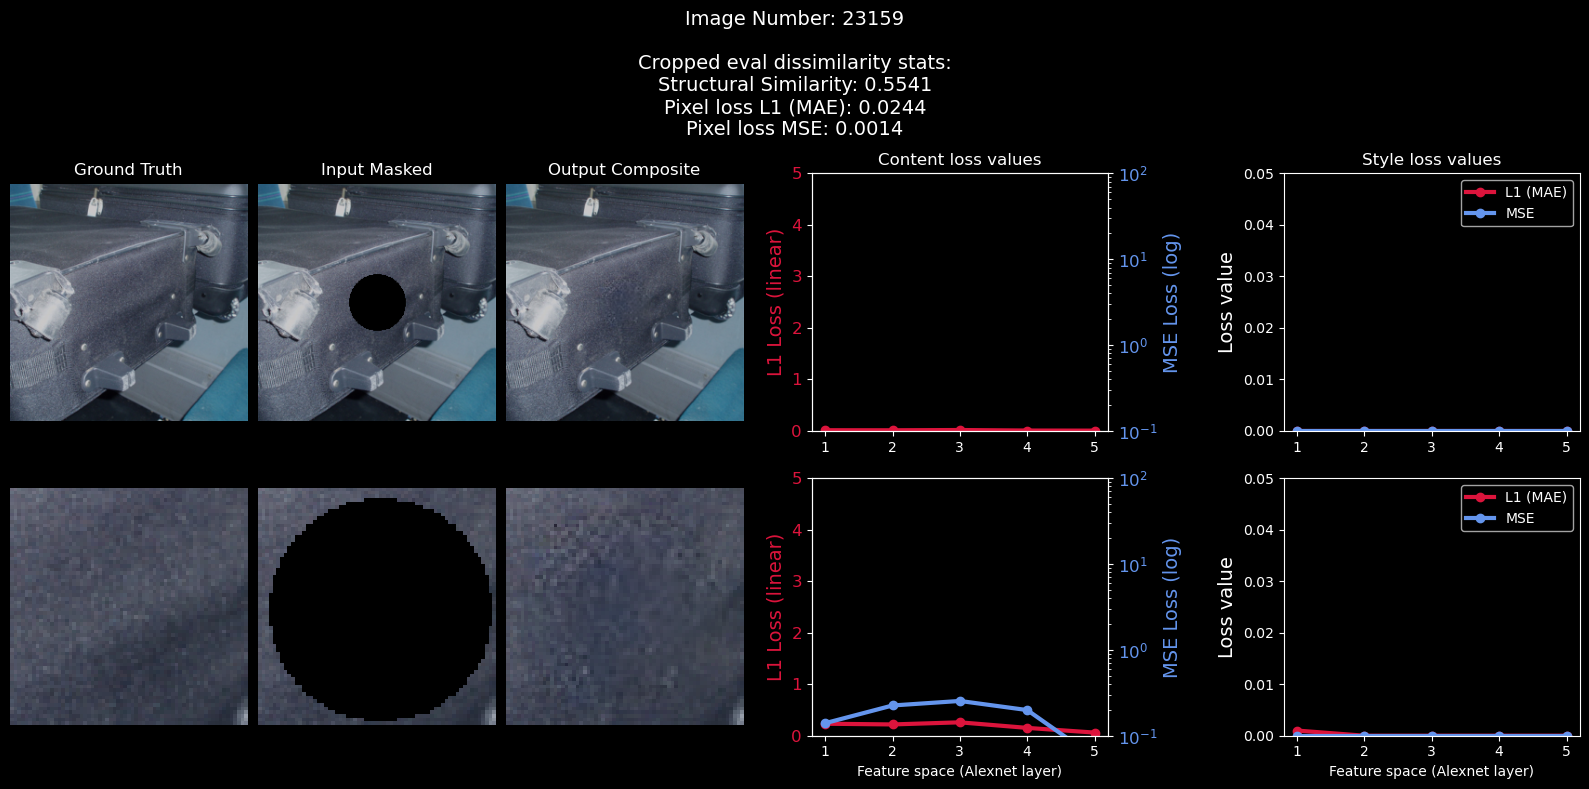

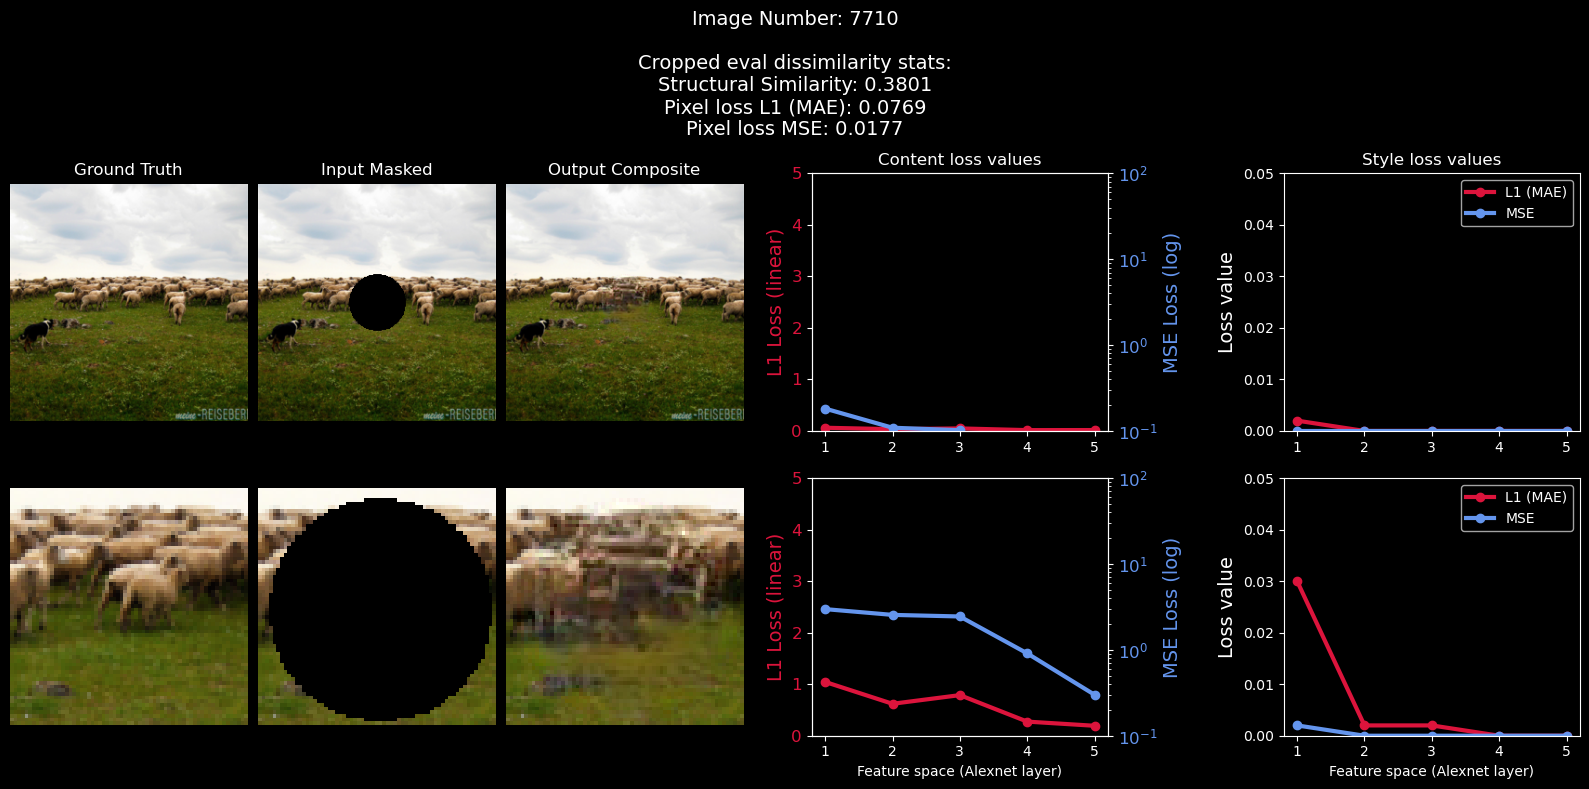

In [92]:
# WORKS! Now it would be nice to also check the images for a subject's specific design matrix
# eval_mask was 1.2

# Fix that it saves a 'feats_gt_np_n.pkl' file everytime it's ran
_ = NSP.stimuli.predplot(
    subject=subject,
    start_img=1,
    n_imgs=2,
    mask_loc="center",
    ecc_max=patchbound,
    select_ices="random",
    cnn_type="alex",
    pretrain_version="places20k",
    eval_mask_factor=np.sqrt(1.2),
    log_y_MSE="y",
)

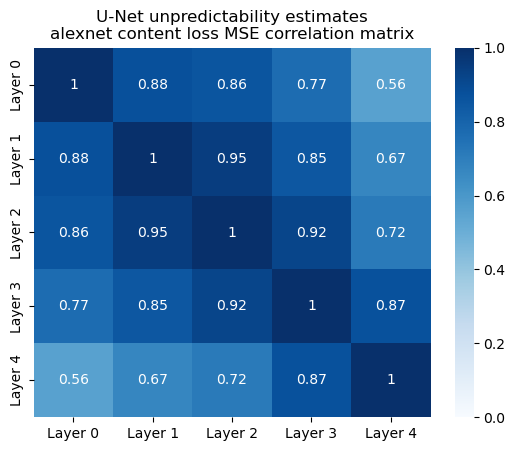

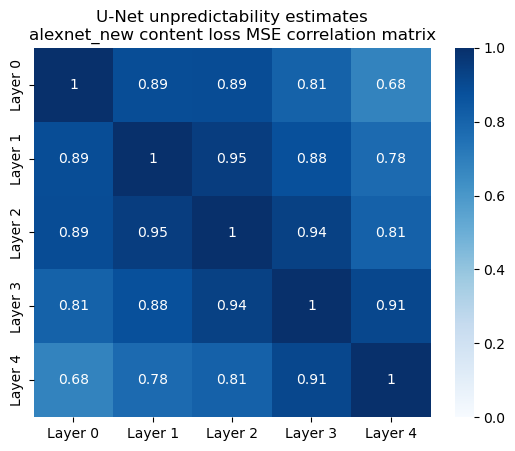

In [121]:
# Inspect the correlation matrix for a specific set of the loss metrics
NSP.stimuli.unpred_corrmatrix(
    type="content", loss_calc="MSE", cmap="Blues", cnn_type="alexnet"
)
NSP.stimuli.unpred_corrmatrix(
    type="content", loss_calc="MSE", cmap="Blues", cnn_type="alexnet_new"
)

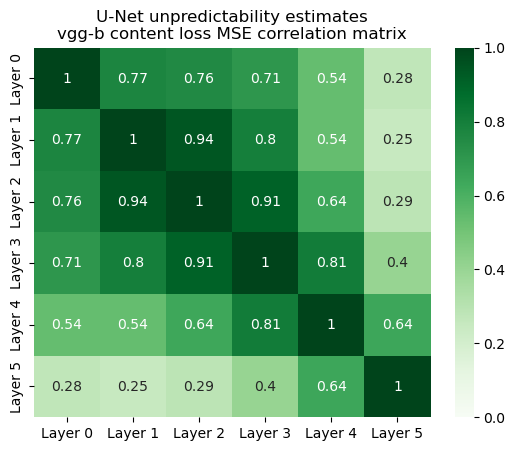

In [93]:
NSP.stimuli.unpred_corrmatrix(type='content', loss_calc='MSE', cmap='Greens', cnn_type='vgg-b')

##### Plot a similar correlation matrix, but also add the baseline contrast features

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


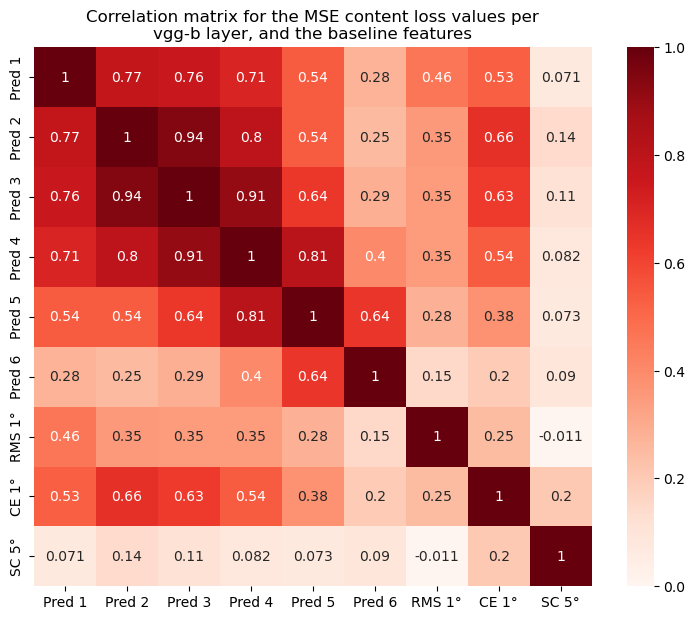

In [232]:
NSP.stimuli.plot_correlation_matrix(
    include_rms=True,
    include_ce=True,
    include_ce_l=False,
    include_sc=False,
    include_sc_l=True,
    cmap="Reds",
    cnn_type="vgg-b",
    loss_calc="MSE",
)

## Feature map extraction from AlexNets

##### Load in a selection of the AlexNet feature maps extracted from the adjusted U-Net class

### Deprecated. I don't use these anymore. Later on adapt the plotting function to the actual ones I'm using right now. But I need to extract the feature extraction (ha ha) part from the encoding scripts that I'm using right now. 

In [ ]:
# These are HUGE. layer1 has 10368 features, layer2 has 31872 features, layer3 has 20224 features, layer4 has 2560 features
Xalex_unet = NSP.stimuli.unet_featmaps(list_layers=[2], scale="full")

##### Inspect the feature maps extracted from UNet

In [4]:
# has indexing bug, try again if error
NSP.stimuli.plot_unet_feats(
    layer=1, batch=0, cmap="gist_earth", subject=subject, scale="full"
)

NameError: name 'subject' is not defined

##### Extracted features from my own alexnet implementation. Finally works

In [25]:
alx1 = NSP.stimuli.alex_featmaps([1], "subj01")

[[ 1.       0.00098  0.00125 -0.00048 -0.00098]
 [ 0.00098  1.       0.00151  0.00011  0.00026]
 [ 0.00125  0.00151  1.       0.00082 -0.00108]
 [-0.00048  0.00011  0.00082  1.      -0.00048]
 [-0.00098  0.00026 -0.00108 -0.00048  1.     ]]


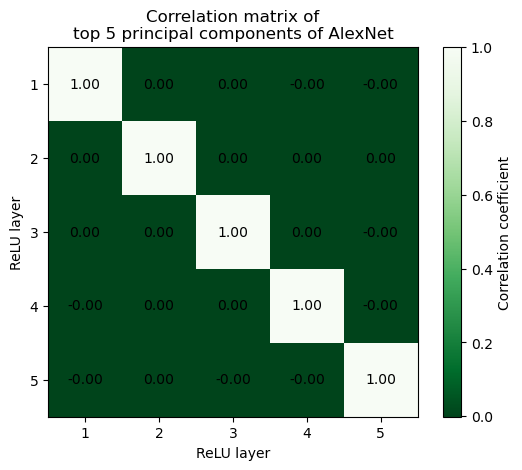

In [94]:
# This is the newest
allex = NSP.stimuli.alex_featmaps(
    layers=[1, 4, 7, 9, 11], subject="subj01", plot_corrmx=True
)

##### Some visual checks of these features

In [9]:
# Be aware that the layer number here is 1 more than the ones of the 'alex_layn.npy' files, because there I do not include the input layer
# so alex_lay0 corresponds with layer1 here.
img_ids, dataset, pca, feature, lay, layname = NSP.stimuli.extract_features(subject='subj01', layer=4,
                                                     start_img=8, n_imgs=2, batch_size=2, pca_components=2,
                                                     verbose=True, img_crop=True)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['input', 'Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Conv2d_3', 'ReLU_3', 'Conv2d_4', 'ReLU_4', 'Conv2d_5', 'ReLU_5', 'MaxPool2d_3', 'Dropout_1', 'Linear_1', 'ReLU_6', 'Dropout_2', 'Linear_2', 'ReLU_7', 'Linear_3']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


  0%|          | 0/1 [00:00<?, ?it/s]

### Turn this into functions

Conv2d_2
The Lord has decided for you to peek into feature space through the lens of gist_ncar_r


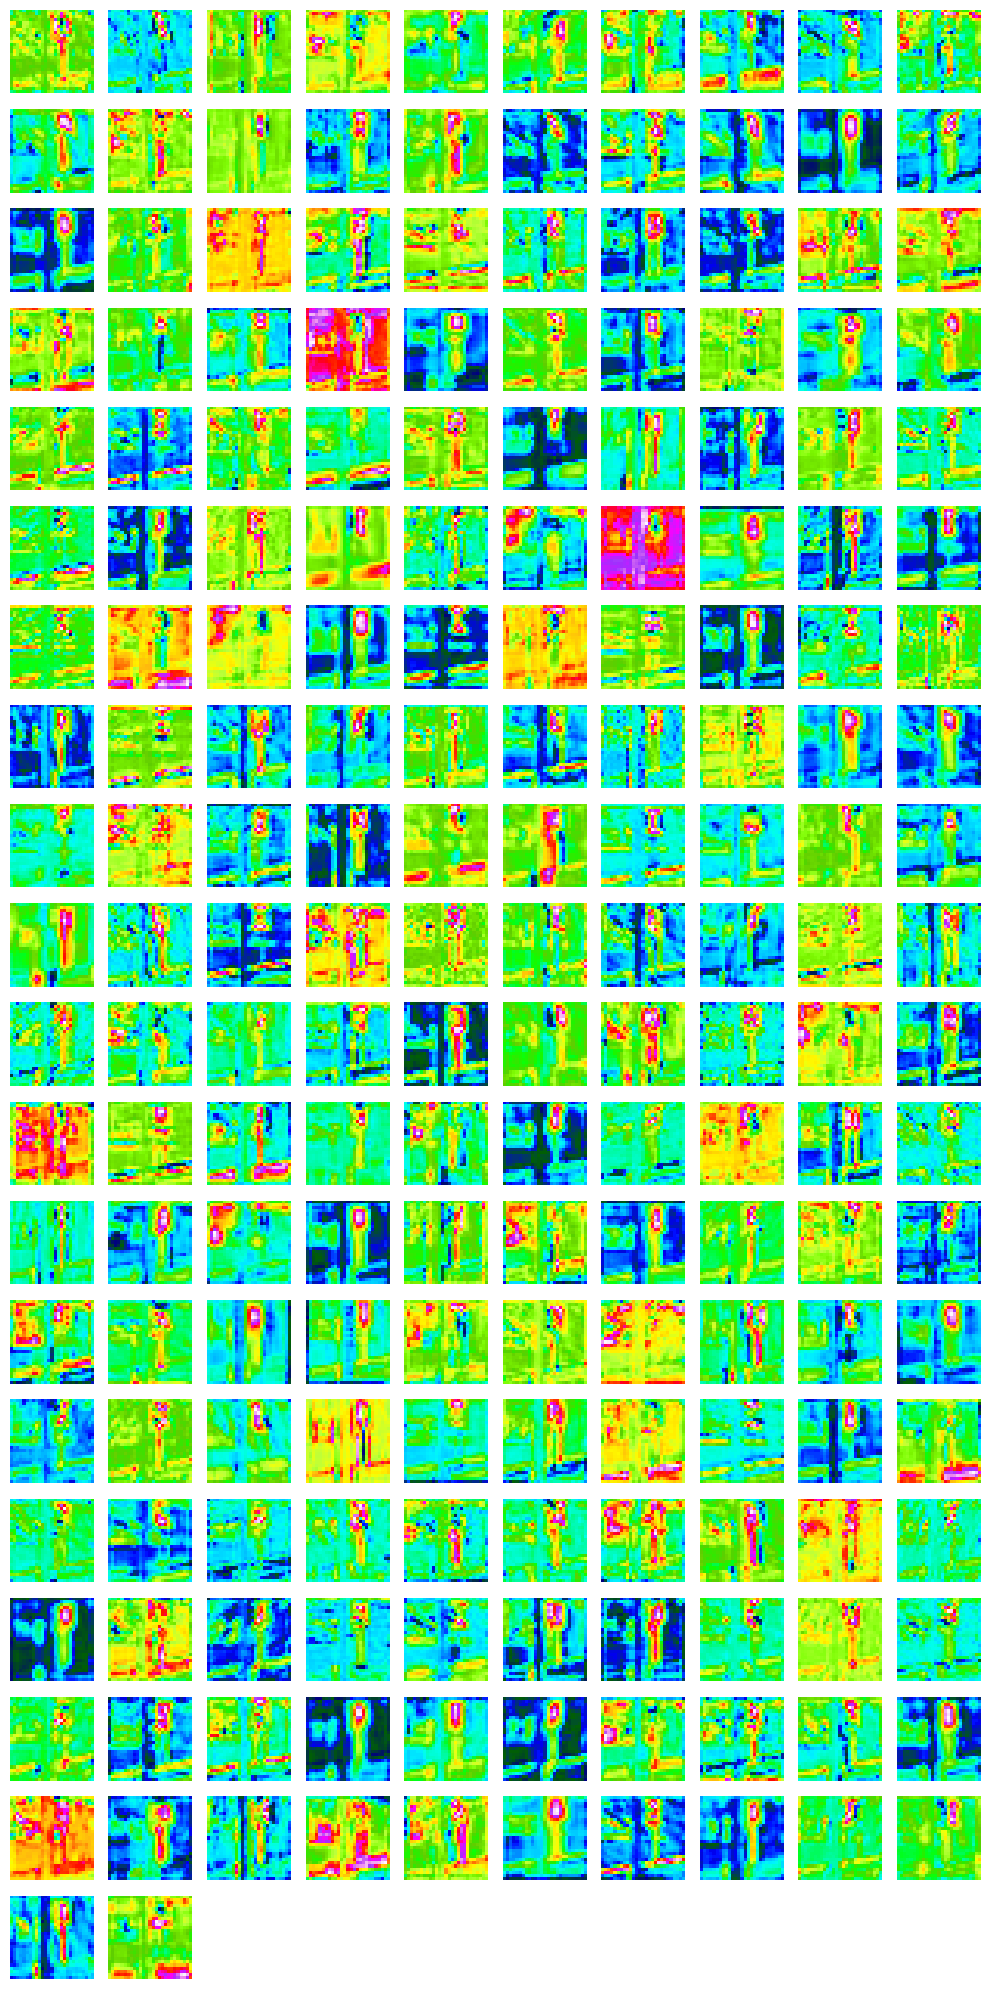

In [11]:
# Plot the feature maps
print(layname)
NSP.stimuli.plot_features(which_img=0, layer=lay, layer_type=layname, img_ids=img_ids, features=feature, num_cols=10, random_cmap=True)

In [29]:
X = NSP.stimuli.unet_featmaps([2], scale='full')  # Get alexfet features
X_shuf = np.copy(X)
np.random.shuffle(X_shuf)

print(X.shape)
NSP.utils.inspect_dat(X)

(3000, 219)
Lowest value: -1.0077283444339864
Highest value: 2.096213559027006
Mean value: -1.7371526169172922e-19
Standard deviation: 0.14668107623422896


### REGRESSIONS

In [122]:
reload_nsp()

soepstengesl
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


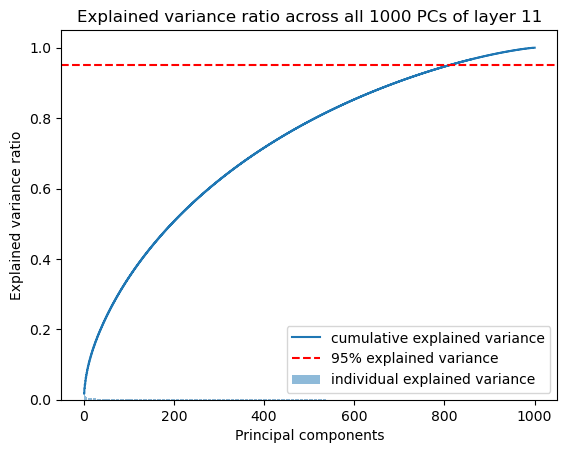

In [130]:
NSP.analyse.explained_var_plot(11, 1000)

In [6]:
X = NSP.stimuli.alex_featmaps(1, "subj01", plot_corrmx=False)
X_shuf = np.copy(X)
np.random.shuffle(X_shuf)

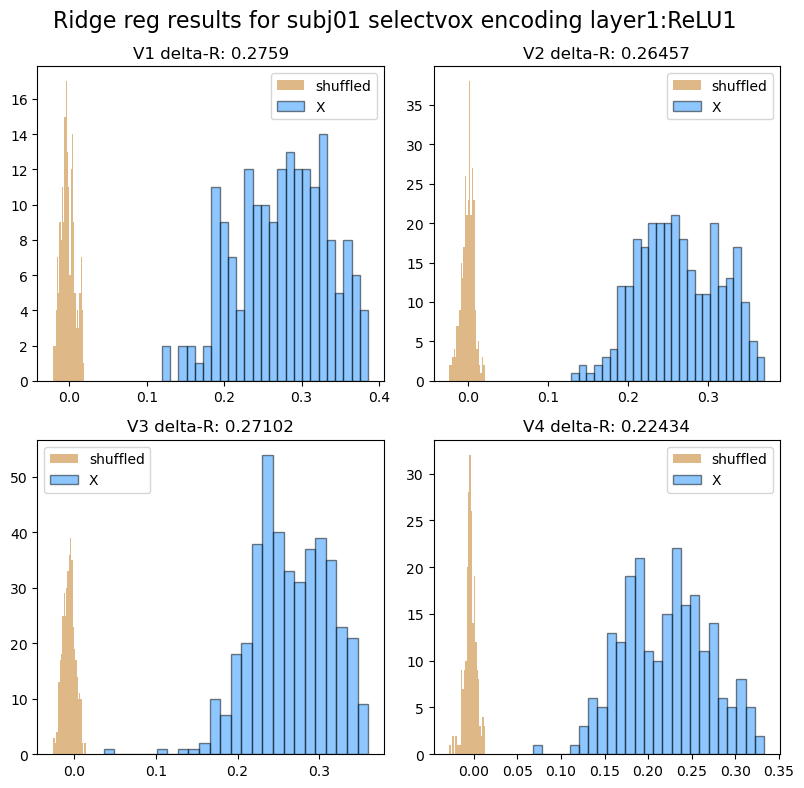

Succesfully saved the outputs to subj01 selectvox encoding layer1:ReLU1_plot.png and subj01 selectvox encoding layer1:ReLU1_regcor_scores.npy


<Figure size 640x480 with 0 Axes>

In [160]:
obj = NSP.analyse.analysis_chain(subject, ydict=ydict, X=X, alpha=10, voxeldict=voxeldict, cv=5,
                                 rois=rois, X_uninformative=X_shuf, fit_icept=False, save_outs=True, regname='subj01 selectvox encoding layer1:ReLU1')

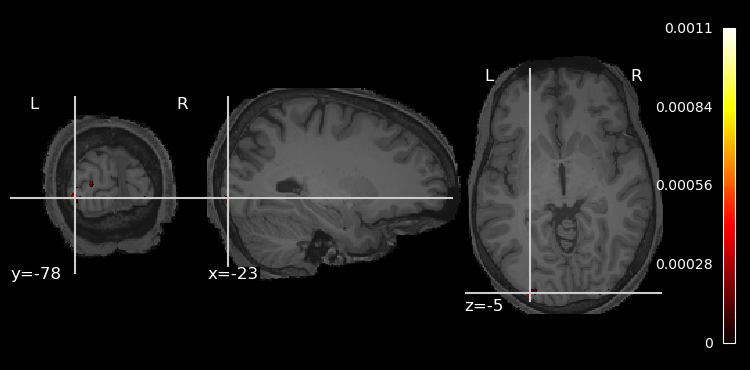

interactive(children=(IntSlider(value=144, description='x', max=432, min=-144), IntSlider(value=6, description…

In [162]:
coords = obj[0]
brain_np = NSP.utils.coords2numpy(np.hstack((np.array(coords)[:,:3],np.array(coords)[:,5].reshape(-1,1))), roi_masks[subject]['V1_mask'].shape, keep_vals=True)

NSP.analyse.plot_brain(prf_dict, roi_masks, subject, NSP.utils.cap_values(np.copy(brain_np), 0, .55), NSP.utils.duplicate_cmap("hot"), save_img=False, img_path='/home/rfpred/imgs/rel_scores_np.png')


NSP.cortex.viscortex_plot(prf_dict=prf_dict, 
                        vismask_dict=roi_masks, 
                        plot_param=None, 
                        subject=subject, 
                        upcap=None, 
                        lowcap=0, 
                        inv_colour=False, 
                        cmap='RdGy',
                        # cmap='seismic',
                        regresult= brain_np)

# # which_cnn = 'vgg-b'
# # layer = 0
# # cordict, coords = NSP.analyse.load_regresults(subject, prf_dict, roi_masks, f'Root Mean Square contrast', None, plot_on_viscortex=True, plot_result='betas', verbose=False)


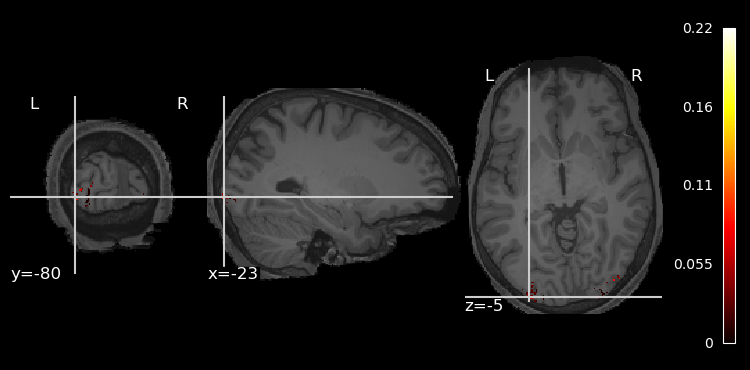

interactive(children=(IntSlider(value=144, description='x', max=432, min=-144), IntSlider(value=6, description…

         x     y     z         r    r_shuf      beta
0     56.0   9.0  74.0  0.006854  0.005547  0.001500
1     56.0  13.0  69.0  0.022692  0.014403  0.001834
2     56.0  14.0  69.0  0.017894  0.012102  0.000852
3     56.0  14.0  70.0  0.035774  0.026090  0.002488
4     57.0   9.0  74.0  0.060553  0.049756  0.005201
..     ...   ...   ...       ...       ...       ...
675  113.0  25.0  68.0  0.213424  0.176422  0.062912
676  113.0  25.0  69.0  0.162604  0.128985  0.036968
677  113.0  26.0  67.0  0.184196  0.154859  0.044813
678  113.0  26.0  68.0  0.178462  0.145559  0.037103
679  114.0  26.0  67.0  0.167754  0.137362  0.043514

[680 rows x 6 columns]


In [274]:
which_cnn = 'vgg-b'
layer = 0
cordict, coords = NSP.analyse.load_regresults(subject, prf_dict, roi_masks, f'{which_cnn}_unpred', f'{str(layer)}', plot_on_viscortex=True, plot_result='betas', verbose=False)


print(coords)

In [63]:
import lgnpy.CEandSC.lgn_statistics
# from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

import importlib
from importlib import reload
import funcs.natspatpred
import unet_recon.inpainting
importlib.reload(funcs.natspatpred)
importlib.reload(unet_recon.inpainting)
importlib.reload(lgnpy.CEandSC.lgn_statistics)

from unet_recon.inpainting import UNet
from funcs.natspatpred import NatSpatPred, VoxelSieve
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

NSP = NatSpatPred()
NSP.initialise()

soepstengesl
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [148]:
NSP = reload_nsp()

soepstengesl
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


#### Getting the encoding layer assignment on a freesurfer brain

## Keep track of this code!!! Important for later

In [75]:

fs_path = f'{NSP.nsd_datapath}/nsddata/freesurfer/{subject}/surf'

# Load left hemisphere surfaces
lh_white_vertices, lh_white_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/lh.white')
lh_pial_vertices, lh_pial_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/lh.pial')

# Similarly load right hemisphere surfaces
rh_white_vertices, rh_white_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/rh.white')
rh_pial_vertices, rh_pial_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/rh.pial')

In [64]:
# Import the FreeSurfer subject
cortex.freesurfer.import_subj(
    "subj01", freesurfer_subject_dir=f"{NSP.nsd_datapath}/nsddata/freesurfer/"
)

b'created by emilya on Sun Jun 23 00:18:21 2019\n'
b'created by emilya on Sun Jun 23 04:38:38 2019\n'
b'created by emilya on Sun Jun 23 00:18:36 2019\n'
b'created by emilya on Sun Jun 23 05:02:54 2019\n'


In [84]:
# Reload the subjects and check whether they've successfully been reloaded in the pycortex database
cortex.db.reload_subjects()
print(cortex.db.subjects.keys())

dict_keys(['S1', 'subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08'])


In [82]:
# Manually set the subjects directory to the specific FreeSurfer directory
os.environ['SUBJECTS_DIR'] = f"{NSP.nsd_datapath}/nsddata/freesurfer/"
print(os.environ['SUBJECTS_DIR'])

/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/


In [94]:
# This might work later. I just need to copy, or sync rather, the fsaverage directory to my own folders. 

import os
import mne


label = mne.read_label(os.path.join(os.environ['SUBJECTS_DIR'], 'fsaverage', 'label', 'lh.wang2015atlas.V1v.label'))
m = np.zeros(cortex.db.fsaverage.surfaces.inflated.get()[0][0].shape[0])
m[label.vertices] = 1
V = cortex.dataset.Vertex(m, 'fsaverage')
cortex.webshow(V)

# /home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01/label/lh.prfeccentricity.mgz

FileNotFoundError: [Errno 2] No such file or directory: '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/fsaverage/label/lh.wang2015atlas.V1v.label'

In [111]:
data.reshape(roi_masks[subject]['V1_mask'].shape)

ValueError: cannot reshape array of size 227021 into shape (145,186,148)

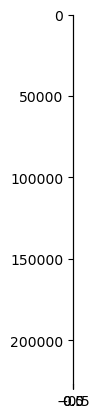

In [109]:

# from nilearn import plotting
file_path = "/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01/label/lh.prfeccentricity.mgz"
import nibabel as nib
import matplotlib.pyplot as plt

# Load the .mgz file
img = nib.load(file_path)

# Get the data from the image
data = img.get_fdata()

# Create a new figure
fig = plt.figure()

# Plot the data
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')

# Save the figure as an image file
# fig.savefig('output.png')

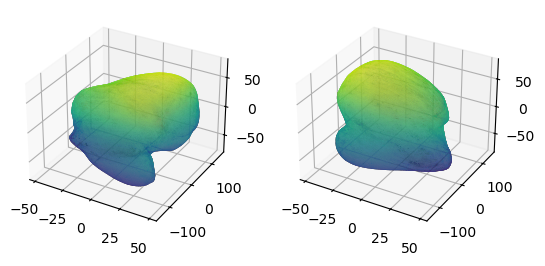

In [91]:
# Get the vertices and faces for each hemisphere
vertices_left, faces_left = cortex.db.get_surf('subj01', 'inflated', 'lh')
vertices_right, faces_right = cortex.db.get_surf('subj01', 'inflated', 'rh')

# Plot the cortical surface for each hemisphere
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
ax[0].plot_trisurf(vertices_left[:, 0], vertices_left[:, 1], faces_left, vertices_left[:, 2], cmap='viridis')
ax[1].plot_trisurf(vertices_right[:, 0], vertices_right[:, 1], faces_right, vertices_right[:, 2], cmap='viridis')
plt.show()

In [77]:

# Visualise the stuff

# Create a Vertex object for each hemisphere
lh_vertex = cortex.Vertex(lh_white_vertices, subject, cmap='hot', vmin=-2, vmax=2)
rh_vertex = cortex.Vertex(rh_white_vertices, subject, cmap='hot', vmin=-2, vmax=2)

# Display the vertices on a flatmap
cortex.quickshow((lh_vertex, rh_vertex))

ValueError: Invalid number of vertices for subject (given 3, should be 227021 for left hem, 226601 for right hem, or 453622 for both)

In [79]:
import cortex

# Get the vertices and faces for each hemisphere
vertices_left, _ = cortex.db.get_surf('subj01', 'lh')
vertices_right, _ = cortex.db.get_surf('subj01', 'rh')

# Get the number of vertices in each hemisphere
num_vertices_left = len(vertices_left)
num_vertices_right = len(vertices_right)

print(f"Number of vertices in left hemisphere: {num_vertices_left}")
print(f"Number of vertices in right hemisphere: {num_vertices_right}")

OSError: 

In [53]:
# Load the .mgz file
trans_r = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/rh.func1pt0-to-pial.mgz')
trans_l = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/lh.func1pt0-to-pial.mgz')

data_r = trans_r.get_fdata()
data_l = trans_l.get_fdata()

In [98]:
# for enc_layer in range(0,5):
for enc_layer in [0]:
    subject = "subj01"
    enc_brain_coords = np.load(
        f"{NSP.own_datapath}/{subject}/brainstats/encoding/allvox_alexunet_layer{enc_layer}_fullviscortex_regcor_scores.npy"
    )
    enc_brain_np = NSP.utils.coords2numpy(
        enc_brain_coords, roi_masks[subject]["V1_mask"].shape, keep_vals=True
        
    )
    # Turn the numpy to a nifti file
    # enc_brain_nii = nib.Nifti1Image(enc_brain_np, affine=np.eye(4))
    enc_brain_nii = nib.Nifti1Image(enc_brain_np, affine=NSP.cortex.anat_templates(prf_dict)[subject].affine)


own_fspath = f'{NSP.own_datapath}/{subject}/freesurfer'
nib.save(enc_brain_nii, f'{own_fspath}/fs_test_enc.nii')

# subjpath = '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01/mri/brain.mgz'
# surfaces = cortex.db.get_surf(subjpath, 'fiducial')


In [99]:
# This runs a terminal command to convert the nifti file to a .mgz file. I'm not sure how good it works
# as it doesn't use any of the transformations given in the NSD dataset files.
import subprocess

# Define the command
command = ['mri_convert', f'{own_fspath}/fs_test_enc.nii', f'{own_fspath}/enc_brain.mgz']

# Run the command
subprocess.run(command, check=True)


mri_convert /home/rfpred/data/custom_files/subj01/freesurfer/fs_test_enc.nii /home/rfpred/data/custom_files/subj01/freesurfer/enc_brain.mgz 
reading from /home/rfpred/data/custom_files/subj01/freesurfer/fs_test_enc.nii...
niiRead(): detected input as 64 bit double, reading in as 32 bit float
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/rfpred/data/custom_files/subj01/freesurfer/enc_brain.mgz...


CompletedProcess(args=['mri_convert', '/home/rfpred/data/custom_files/subj01/freesurfer/fs_test_enc.nii', '/home/rfpred/data/custom_files/subj01/freesurfer/enc_brain.mgz'], returncode=0)

In [104]:
# Print the shape of the volume
print(vol_r.data.shape)

# Print the first few values of the volume
print(vol_r.data[:10])

NameError: name 'vol_r' is not defined

In [38]:
# Load the .mgz file
trans_r = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/rh.func1pt0-to-pial.mgz')
trans_l = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/lh.func1pt0-to-pial.mgz')

# Get the data from the .mgz file
data_r = trans_r.get_fdata()
data_l = trans_l.get_fdata()



# # Change the order of the axes from xyz to zyx
# data_r = np.transpose(data_r, (2, 1, 0))
# data_l = np.transpose(data_l, (2, 1, 0))

# Create a pycortex Volume
vol_r = cortex.Volume(data_r, '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01', 'identity', vmin=None, vmax=None, cmap='hot')
vol_l = cortex.Volume(data_l, '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01', 'identity', vmin=None, vmax=None, cmap='hot')

# Display the volume
cortex.webgl.show(vol_r)
cortex.webgl.show(vol_l)

(226601, 1, 1, 3)


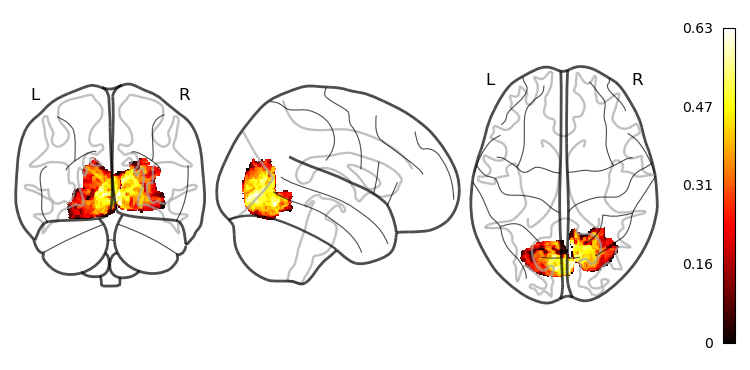

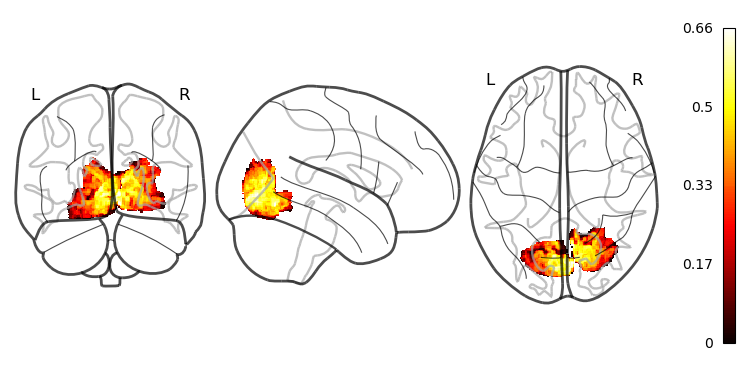

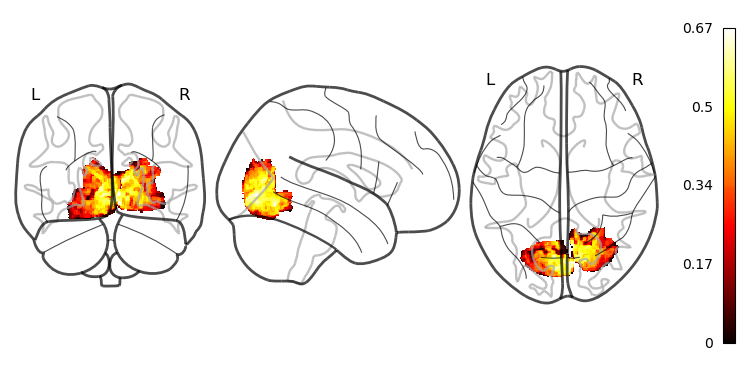

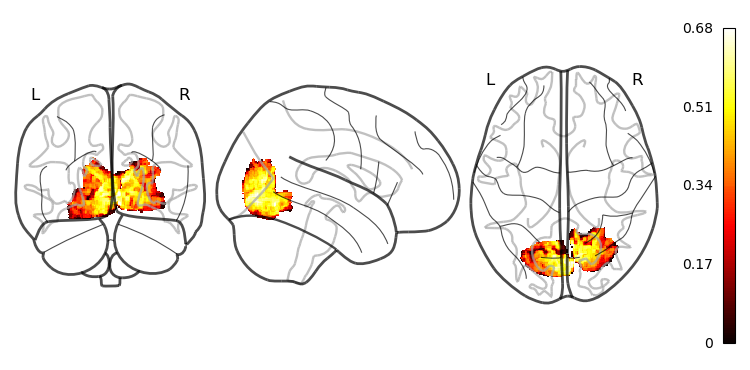

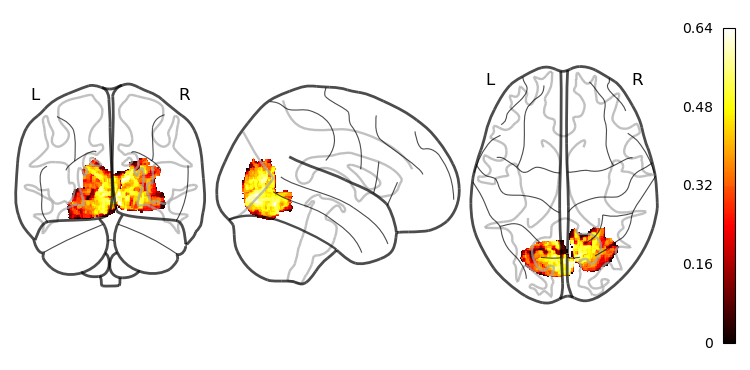

In [14]:

    NSP.analyse.plot_brain(
        prf_dict,
        roi_masks,
        subject,
        enc_brain_np,
        NSP.utils.duplicate_cmap("hot"),
        glass_brain=True,
        save_img=True,
        img_path=f"{NSP.own_datapath}/{subject}/brainstats/encoding/allvox_alexunet_layer{enc_layer}_fullviscortex_regcor_scores_glass.png",
    )

seukken


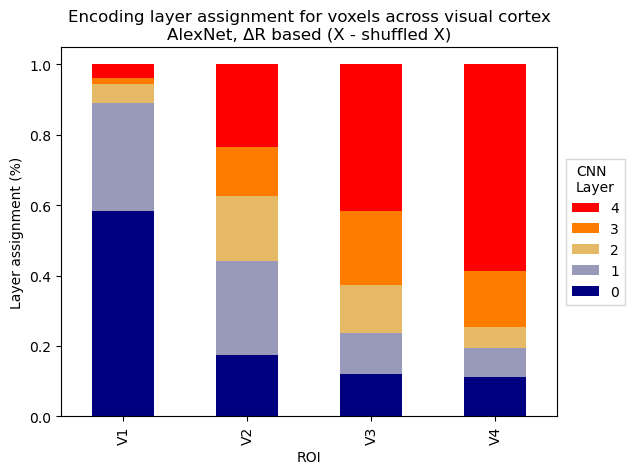

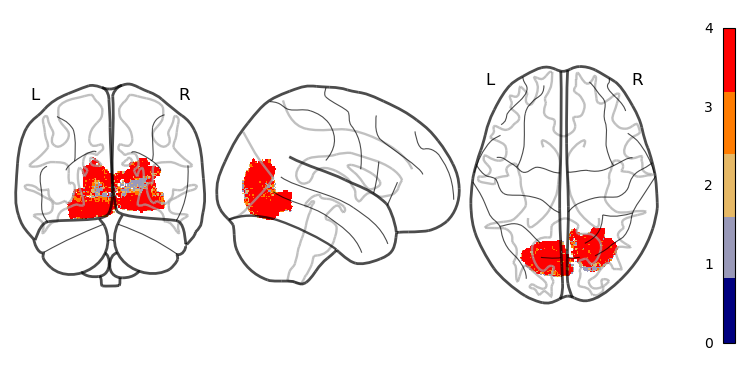

In [152]:
# Layer assignment of the encoding analyses of AlexNet, beautiful
NSP.analyse.assign_layers('subj01',
                          prf_dict,
                          roi_masks,
                          rois,
                          'soup',
                          'alex',
                          True,
                          '_fullviscortex',
                          False,
                          'delta_r',
                          which_reg='encoding',
                          man_title='Encoding layer assignment for voxels across visual cortex\nAlexNet, ΔR based (X - shuffled X)')

In [43]:
NSP = reload_nsp()

soepstengesl
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


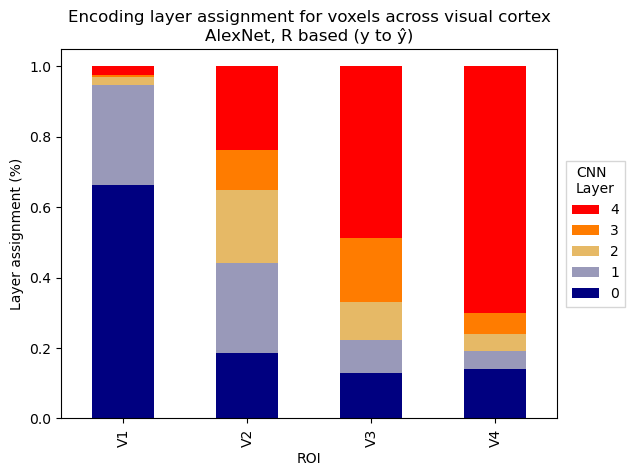

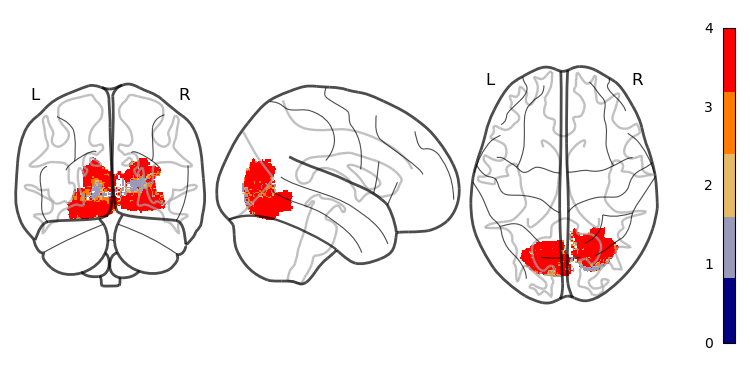

In [45]:
# Layer assignment of the encoding analyses of AlexNet, beautiful
ass_brain = NSP.analyse.assign_layers('subj01',
                          prf_dict,
                          roi_masks,
                          rois,
                          'soup',
                          'alexnet',
                          True,
                          '_fullviscortex',
                          True,
                          'r',
                          which_reg='encoding',
                          man_title='Encoding layer assignment for voxels across visual cortex\nAlexNet, R based (y to ŷ)',
                          return_nifti=True)

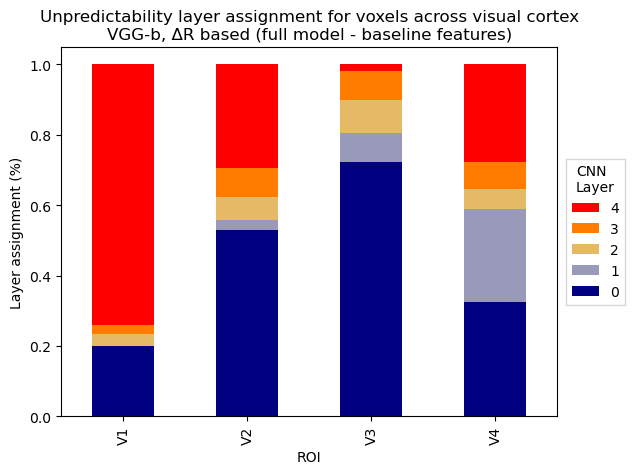

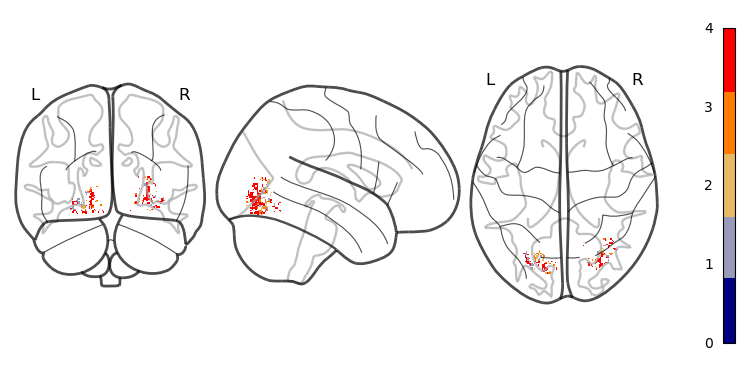

In [79]:
NSP.analyse.assign_layers(
    "subj01",
    prf_dict,
    roi_masks,
    rois,
    "",
    cnn_type="alexnet",
    plot_on_brain=True,
    file_tag="_nieuw",
    save_imgs=True,
    basis_param='delta_r',
    which_reg='unpred',
    man_title='Unpredictability layer assignment for voxels across visual cortex\nVGG-b, ΔR based (full model - baseline features)',
)

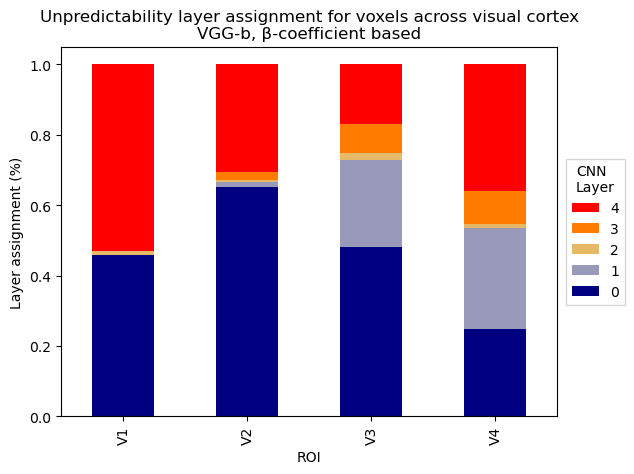

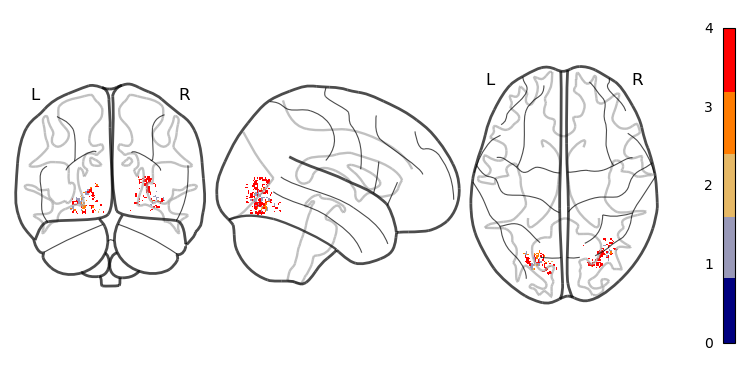

In [74]:
NSP.analyse.assign_layers(
    "subj01",
    prf_dict,
    roi_masks,
    rois,
    "",
    cnn_type="alexnet",
    plot_on_brain=True,
    file_tag="_nieuw",
    save_imgs=True,
    man_title='Unpredictability layer assignment for voxels across visual cortex\nVGG-b, β-coefficient based',
)

##### This codeblock retrieves the roi-specific delta r scores for each AlexNet layer

TURN INTO METHOD

In [88]:
# THIS IS HOW I MANAGED TO LOAD IN ALL THE NEWLY COMPUTED VGG-B UNPRED FEATS
alexnew = NSP.datafetch.load_pred_estims(subject='subj01', verbose=True, cnn_type='alexnet')

alexnewdf = pd.DataFrame(alexnew)

# Convert each list of values into separate rows
df_exploded = alexnewdf.apply(lambda x: x.explode())

# Reset the index
df_exploded.reset_index(drop=True, inplace=True)
df_exploded.to_csv('./data/custom_files/visfeats/pred/all_predestims_alexnet_new.csv', index=False)


Now loading file 1 of 146
Now loading file 2 of 146
Now loading file 3 of 146
Now loading file 4 of 146
Now loading file 5 of 146
Now loading file 6 of 146
Now loading file 7 of 146
Now loading file 8 of 146
Now loading file 9 of 146
Now loading file 10 of 146
Now loading file 11 of 146
Now loading file 12 of 146
Now loading file 13 of 146
Now loading file 14 of 146
Now loading file 15 of 146
Now loading file 16 of 146
Now loading file 17 of 146
Now loading file 18 of 146
Now loading file 19 of 146
Now loading file 20 of 146
Now loading file 21 of 146
Now loading file 22 of 146
Now loading file 23 of 146
Now loading file 24 of 146
Now loading file 25 of 146
Now loading file 26 of 146
Now loading file 27 of 146
Now loading file 28 of 146
Now loading file 29 of 146
Now loading file 30 of 146
Now loading file 31 of 146
Now loading file 32 of 146
Now loading file 33 of 146
Now loading file 34 of 146
Now loading file 35 of 146
Now loading file 36 of 146
Now loading file 37 of 146
Now loadin

In [66]:
# THIS IS HOW I MANAGED TO LOAD IN ALL THE NEWLY COMPUTED VGG-B UNPRED FEATS
vggb = NSP.datafetch.load_pred_estims(subject='subj01', verbose=False)

vggdf = pd.DataFrame(vggb)

# Convert each list of values into separate rows
df_exploded = vggdf.apply(lambda x: x.explode())

# Reset the index
df_exploded.reset_index(drop=True, inplace=True)
df_exploded.to_csv('./data/custom_files/all_predestims_vgg-b.csv', index=False)


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'vgg-b_all'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_279429/3275422686.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block0_values] [items->Index(['content_loss_0_L1', 'content_loss_0_MSE', 'content_loss_1_L1',
       'content_loss_1_MSE', 'content_loss_2_L1', 'content_loss_2_MSE',
       'content_loss_3_L1', 'content_loss_3_MSE', 'content_loss_4_L1',
       'content_loss_4_MSE', 'content_loss_5_L1', 'content_loss_5_MSE',
       'img_ices', 'pixel_loss_L1', 'pixel_loss_MSE', 'pixel_loss_hole_L1',
       'pixel_loss_hole_MSE', 'ssim', 'style_loss_0_L1', '

In [166]:
df = pd.read_csv('./data/custom_files/visfeats/pred/all_predestims_alexnet_new.csv')

In [167]:
df

content_loss_0_L1  content_loss_0_MSE  content_loss_1_L1  \
0               0.175234            1.763462           0.362029   
1               0.041866            1.990399           0.162246   
2               0.063377            1.920925           0.136010   
3               0.131791            1.301148           0.222084   
4               0.165838            2.275560           0.352181   
...                  ...                 ...                ...   
72995           0.625063            1.379304           0.552360   
72996           1.729658            7.526821           0.881460   
72997           0.590949            1.078146           0.434140   
72998           0.403451            0.713266           0.391278   
72999           0.908554            2.223469           0.760978   

       content_loss_1_MSE  content_loss_2_L1  content_loss_2_MSE  \
0                0.875058           0.293231            1.154451   
1                1.532135           0.099899            1.442462   
2                1.474215           0.100416            1.411541   
3                1.291433           0.184696            1.250224   
4                2.097053           0.245869            1.880571   
...                   ...                ...                 ...   
72995            1.694984           0.447574            1.073832   
72996            6.978585           1.132173            5.475585   
72997            1.083270           0.608827            1.291659   
72998            0.973173           0.338597            0.650160   
72999            3.964289           0.766519            2.841989   

       content_loss_3_L1  content_loss_3_MSE  content_loss_4_L1  \
0               0.256250            0.564202           0.144810   
1               0.090368            0.823986           0.050968   
2               0.091984            0.722432           0.059680   
3               0.180368            0.684320           0.113261   
4               0.239390            1.298779           0.169639   
...                  ...                 ...                ...   
72995           0.212012            0.468271           0.180593   
72996           0.372045            1.787149           0.267559   
72997           0.287080            0.811648           0.261969   
72998           0.177878            0.345595           0.122387   
72999           0.414415            1.540867           0.325691   

       content_loss_4_MSE  ...  style_loss_0_L1  style_loss_0_MSE  \
0                0.205410  ...         0.001152          0.000460   
1                0.323672  ...         0.000202          0.000502   
2                0.368616  ...         0.000245          0.000425   
3                0.292164  ...         0.000801          0.000292   
4                0.636944  ...         0.001149          0.000807   
...                   ...  ...              ...               ...   
72995            0.207414  ...         0.012864          0.000417   
72996            0.518888  ...         0.075034          0.009552   
72997            0.501547  ...         0.011904          0.000321   
72998            0.145485  ...         0.007544          0.000298   
72999            0.708480  ...         0.021162          0.001010   

       style_loss_1_L1  style_loss_1_MSE  style_loss_2_L1  style_loss_2_MSE  \
0             0.000937          0.000005         0.000270          0.000005   
1             0.000691          0.000016         0.000084          0.000004   
2             0.000256          0.000016         0.000069          0.000004   
3             0.000588          0.000014         0.000150          0.000004   
4             0.001211          0.000033         0.000261          0.000007   
...                ...               ...              ...               ...   
72995         0.002679          0.000030         0.000826          0.000002   
72996         0.004663          0.000277         0.002623          0.000030   
72997         0.001499          0.000011

In [129]:
df = pd.read_csv('./data/custom_files/visfeats/pred/all_predestims_vgg-b.csv')

In [187]:
# feats = NSP.stimuli.features()['all_predestims_vgg-b.csv']

Xpred_vggb = NSP.stimuli.unpred_feats(cnn_type='vgg-b', content=True, style=False, ssim=False, pixel_loss=False, 
                                      L1=False, MSE=True, verbose=True, outlier_sd_bound=5, subject='subj01')



Could not load mat file with mat73 - trying to load with scipy.io.loadmat!
['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE', 'content_loss_5_MSE']


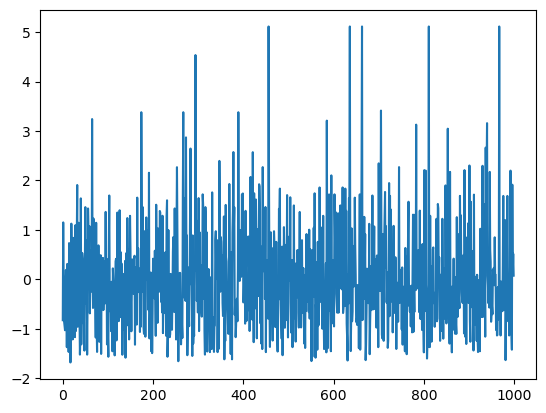

In [197]:
plt.plot(Xpred_vggb[:,4][3000:4000])

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site

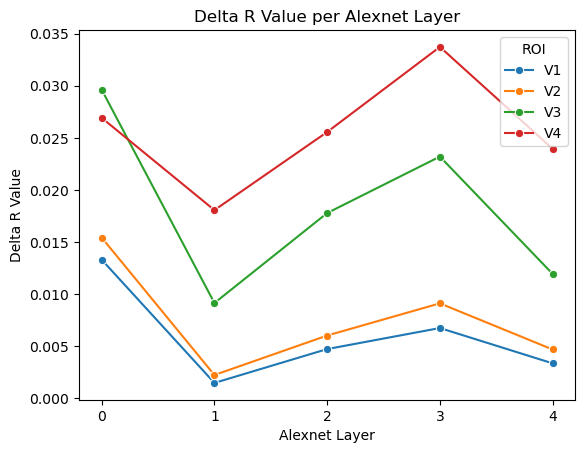

In [76]:
import seaborn as sns
# df = df.drop(columns='level_0')

# Reset the index of the DataFrame to use it as x-axis
df.reset_index(inplace=True)

# Drop the 'level_0' column
# df = df.drop(columns='level_0')

# Melt the DataFrame to long-form or tidy format
df_melted = df.melt('index', var_name='ROI', value_name='b')

# Create the line plot
sns.lineplot(x='index', y='b', hue='ROI', data=df_melted, marker='o')

plt.xticks(range(5))  # Set x-axis ticks to be integers from 0 to 4
plt.xlabel('Alexnet Layer')
plt.ylabel('Delta R Value')
plt.title('Delta R Value per Alexnet Layer')
plt.show()

#### Turn this into a function, so only need 1 line to show every regression result tomorrow

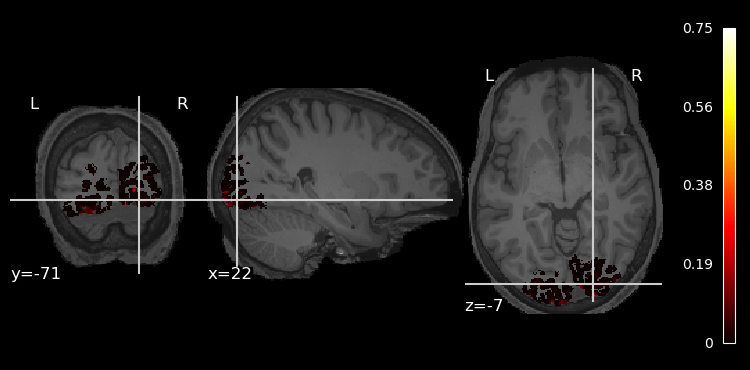

interactive(children=(IntSlider(value=144, description='x', max=432, min=-144), IntSlider(value=6, description…

In [83]:
# rel_obj = np.hstack((obj[:,:3], (obj[:,3] - obj[:,4]).reshape(-1,1)))
# # del rel_obj
# rel_scores_np = NSP.utils.coords2numpy(rel_obj, roi_masks[subject][f'{roi}_mask'].shape, keep_vals=True)

rel_obj = np.hstack((obj[0][:,:3], (obj[0][:,3] - obj[0][:,4]).reshape(-1,1)))

rel_scores_np = NSP.utils.coords2numpy(rel_obj, roi_masks[subject][f'{roi}_mask'].shape, keep_vals=True)

NSP.analyse.plot_brain(prf_dict, roi_masks, subject, NSP.utils.cap_values(np.copy(rel_scores_np), 0, 2), False, save_img=True, img_path='/home/rfpred/imgs/rel_scores_np.png')

# # NSP.utils.inspect_dat(all_np)

NSP.cortex.viscortex_plot(prf_dict=prf_dict, 
                          vismask_dict=roi_masks, 
                          plot_param=None, 
                          subject=subject, 
                          upcap=3, 
                          lowcap=None, 
                          inv_colour=False, 
                          cmap='RdGy_r',
                          regresult= all_np)

In [262]:
X = np.linspace(0, 10, 100).reshape(-1,1)
# print(X)
y = np.copy(X)

model = NSP.analyse.run_ridge_regression(X, y, alpha=10, fit_icept=False)
_, cor_scores = NSP.analyse.score_model(X, y, model, cv=2)
cor_scores


# plt.scatter(X,y)

[array([1.]), array([1.])]

In [264]:
# Load ins
print(voxeldict['V1'].attributes)
y = ydict['V1'] # Get the HRF betas for the specified voxel requirements and use as y-matrix
# X = Xrms
# X = NSP.stimuli.unet_featmaps([2, 3]) # Get alexfet features

# layer_nos = [4, 7, 9, 11] # Which layers to take the extracted feature maps from
# Xalex_own = NSP.stimuli.alex_featmaps(layer_nos, pcs_per_layer='all', subject='subj01')

# X = Xpred # This one is not z-scored I see

# X = np.ones((Xrms.shape))
# X = Xce

print(y.shape, X.shape)

['angle', 'ecc', 'nsd_R2', 'patchbound', 'prf_R2', 'sigmas', 'size', 'vox_pick', 'xcoor', 'xyz', 'ycoor']
(30000, 558) (30000, 3)


In [251]:
# Fit a ridge regression model to the data
model = NSP.analyse.run_ridge_regression(X, y, alpha=100)

In [252]:
# Get the resulting beta coefficients for every voxel
betas = model.coef_

In [253]:
y_hats, cor_scores = NSP.analyse.score_model(X, y, model, cv=5)

[ 0.03756  0.0429   0.02589  0.10515  0.03392 -0.01176  0.03264  0.00033
  0.03633 -0.0103  -0.00801  0.01637 -0.00312  0.09673 -0.00451  0.19532
  0.19414  0.03875  0.02269  0.05873  0.09576  0.15453  0.12171  0.04736
  0.02426  0.0408   0.09098  0.0384   0.01792  0.01347  0.00079  0.02757
  0.00355  0.06584  0.02167  0.06915  0.26264  0.06043  0.14146  0.10541
  0.24449  0.01047 -0.00152  0.63046  1.24257  0.13689  0.34908  0.00276
  0.10229  0.18698  1.40212  0.13188  1.2273   0.88551  0.13417  0.02665
  0.00961  0.00986  0.08366  0.05443  2.98769 -0.00022  1.59044  0.0728
  0.07424  0.01353  5.6079   0.02838  0.01542  0.00816  1.69399  0.14448
  0.02519  0.00139  0.00763  2.18988  0.00798  0.04678  0.00045  0.12241
  0.0072   0.06883  0.02151  0.14969  0.06375  0.1318   0.12079  0.04705
  0.01727  0.05031  0.05873  0.00892]


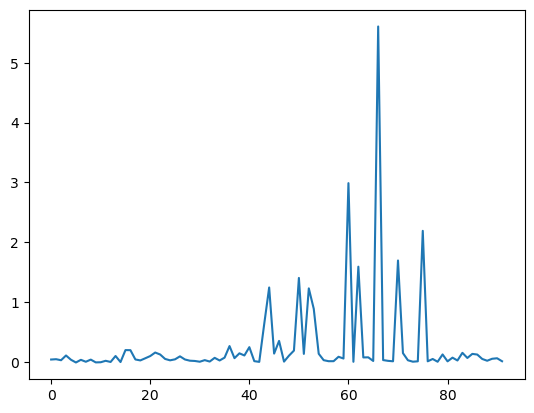

In [27]:
_=plt.plot((np.mean(cor_scores, axis=0))) # THis is averaged r values across folds for every voxel.
print(np.mean(cor_scores, axis=0))

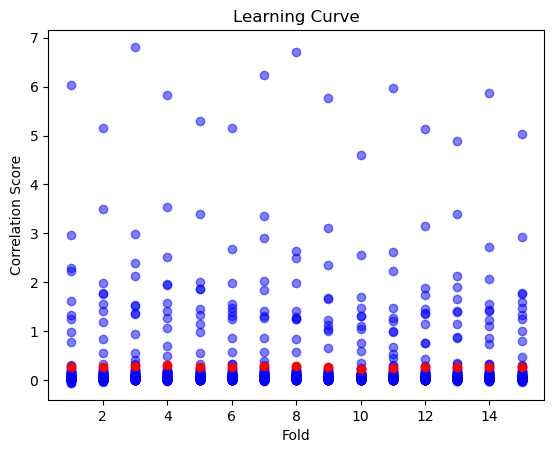

In [268]:
# plt.hist(cor_scores[10]) # So these are the values that indicate the extent to which the y and y_hat correlate.

vox = 19
fold=19
# plt.scatter(y[:,vox], y_hats[:,vox])
# print((cor_scores[fold][vox]))

# print(y.shape)
# print(y_hats.shape)

NSP.analyse.plot_learning_curve(X, y, model, 1, 15)

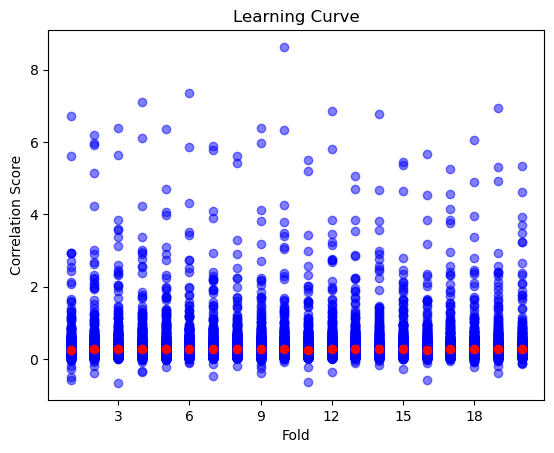

In [121]:
# y, xyzs = NSP.analyse.load_y('subj01', 'V1', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 100, start_img = 0, n_imgs = 3750, across_rois=True)
# y = NSP.datafetch._stack_betas('subj01', 'V2', True, 40)[:,3:].T
y = V1yselect.T
# plt.plot(y)
Xrms = NSP.stimuli.baseline_feats('rms')
# Xce = NSP.stimuli.baseline_feats('ce')
# Xsc_l = NSP.stimuli.baseline_feats('sc_l')
Xalex_unet = NSP.stimuli.unet_featmaps([3])

# X = np.ones((Xce.shape))
# X = NSP.stimuli.baseline_feats('ce_l')
X = Xalex_unet
model = NSP.analyse.run_ridge_regression(X, y, alpha=1)
betas = model.coef_ # This returns a beta coefficient for every voxel
# y_hats, cor_scores = NSP.analyse.score_model(Xpred, y, model, cv=5)
NSP.analyse.plot_learning_curve(X, y, model, 1, 20)


# cor_scores is a list with the voxel correlation scores for each cross-validation fold

### Do'nt forget to scale the betas, z00000scoror

#### Also check for irrelevant RMS values, beacuse it seems now as if anything yields nice results. Adapt the NSP.features.baseline thign to also 
#### include the irrelevant rms vlues.

In [97]:
# Took 2m 48s
for roi in rois:
    Xrms = NSP.stimuli.baseline_feats('rms')
    X = X_all
    betas = NSP.datafetch._stack_betas('subj01', roi, True, 40)
    y = betas[:,3:].T
    model = NSP.analyse.run_ridge_regression(X, y, alpha=.01)


    xyztest =(betas[:, :3])
             
    y_hats, cor_scores = NSP.analyse.score_model(X, y, model, cv=20)

    cor_means = np.mean(np.array(cor_scores), axis=0)
    if roi == 'V1':
        xyztest_stack = xyztest
        cor_means_stack = cor_means
    else: 
        xyztest_stack = np.vstack((xyztest_stack, xyztest))         
        cor_means_stack = np.hstack((cor_means_stack, cor_means))

brainresults = np.hstack((xyztest_stack, cor_means_stack.reshape(-1,1)))
np.save(f'/home/rfpred/data/custom_files/{subject}/brainstats/ce_viscortex.npy', brainresults)

NSP.analyse.plot_learning_curve(X, y, model, 1.0, 20)

# NSP.analyse.stat_on_brain(prf_dict, roi_masks, 'subj01', cor_means, xyzs, True)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

NameError: name 'cv' is not defined

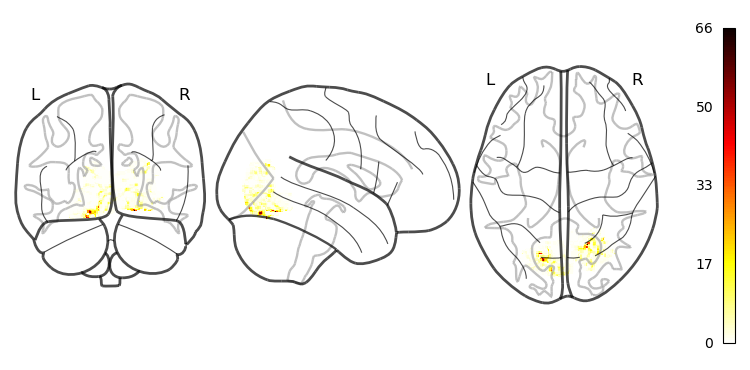

In [16]:
NSP.analyse.stat_on_brain(prf_dict, roi_masks, 'subj01', cor_means_stack, xyztest_stack, True)
# Xpred_results_brain = NSP.utils.coords2numpy(Xpred_results, roi_masks['subj01']['V1_mask'].shape, keep_vals=True)
# NSP.analyse.plot_brain(prf_dict, roi_masks, 'subj01', Xpred_results_brain, True)

Lowest value: -0.1852293430558951
Highest value: 63.48897093496528
Mean value: 0.44784907224832127
Standard deviation: 1.6281024405129818
There are 36 of these voxels


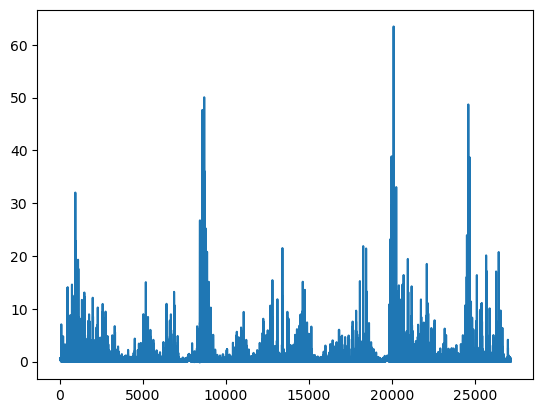

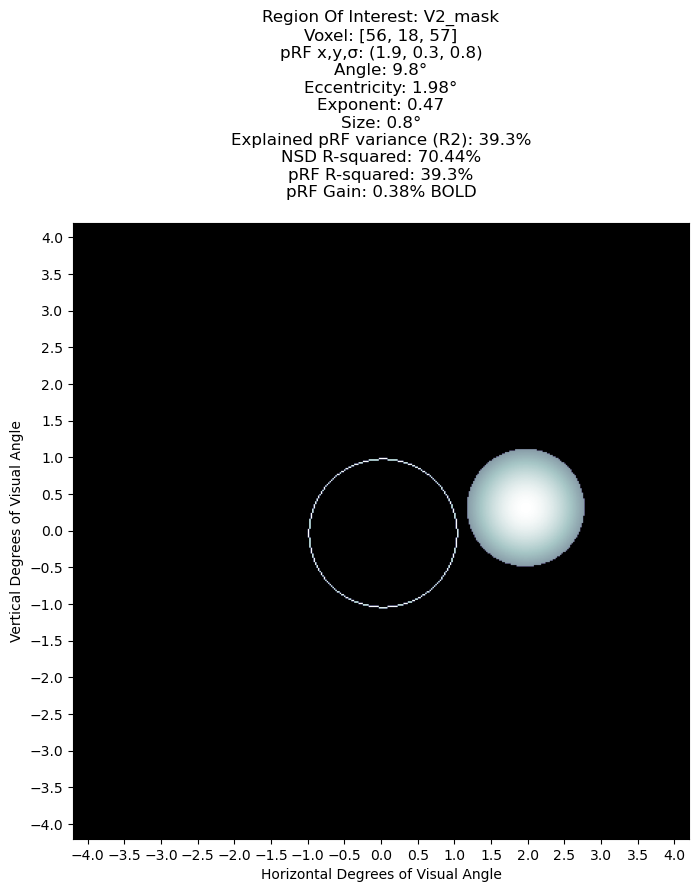

In [98]:
# DEfinitely turn this into a function, also couple with the heatmap stuff (ONCE MADE EFFICIENT). 
# Based on the highest correlation values resulting from the ridge reg, I can then plot the voxels that yield
# THe highest correlation values between y and yhat, as a sort of 'decoding validation'. Potentially very cool as an
# extra check to validate that certain visual features explain the activity best of the voxels with their pRFs inside the
# patch for which we calculated it. 
NSP.utils.inspect_dat(cor_means_stack)
plt.plot(cor_means_stack)
ices = cor_means_stack > 20
goodxyzs = xyztest_stack[ices]
print(f'There are {goodxyzs.shape[0]} of these voxels')

which_voxel = random.randint(0, goodxyzs.shape[0])
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        add_central_patch=True,
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=tuple(goodxyzs[which_voxel].astype(int)))

Lowest value: -0.2281478432195704
Highest value: 64.54057606785801
Mean value: 0.4493600181176349
Standard deviation: 1.6362796812565403
There are 132 of these voxels


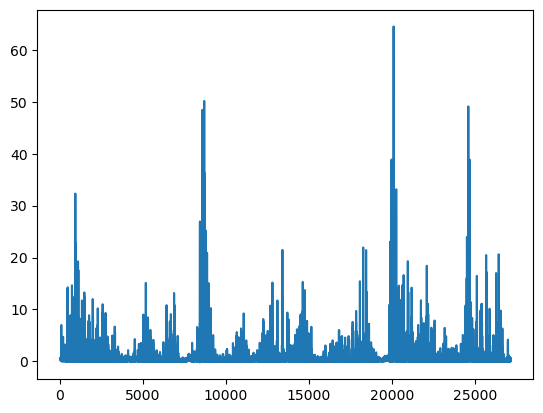

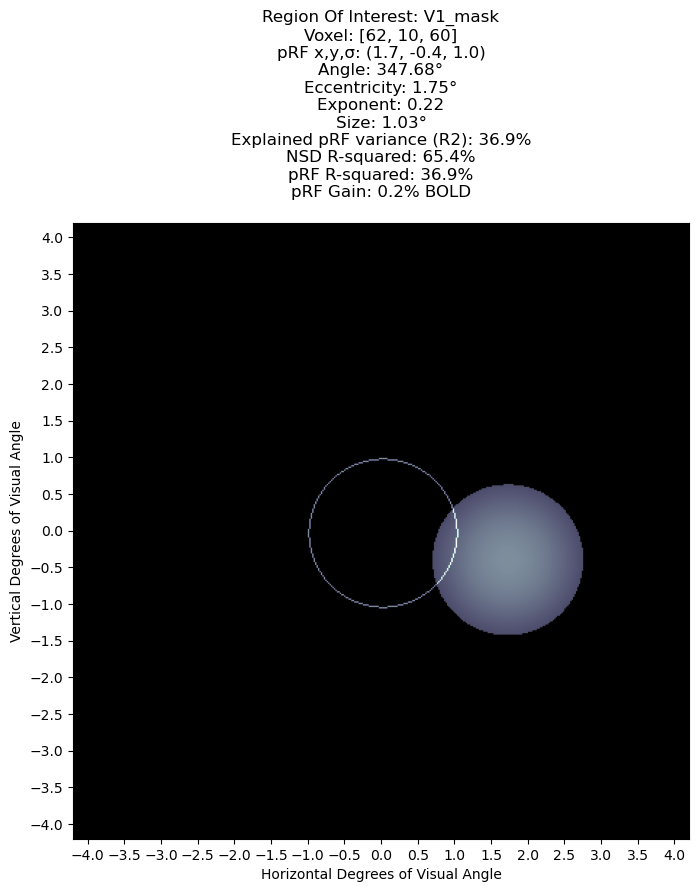

In [76]:
# DEfinitely turn this into a function, also couple with the heatmap stuff (ONCE MADE EFFICIENT). 
# Based on the highest correlation values resulting from the ridge reg, I can then plot the voxels that yield
# THe highest correlation values between y and yhat, as a sort of 'decoding validation'. Potentially very cool as an
# extra check to validate that certain visual features explain the activity best of the voxels with their pRFs inside the
# patch for which we calculated it. 
NSP.utils.inspect_dat(cor_means_stack)
plt.plot(cor_means_stack)
ices = cor_means_stack > 10
goodxyzs = xyztest_stack[ices]
print(f'There are {goodxyzs.shape[0]} of these voxels')

which_voxel = random.randint(0, goodxyzs.shape[0]-1)
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        add_central_patch=True,
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=tuple(goodxyzs[which_voxel].astype(int)))

In [37]:
y, xyzs = NSP.analyse.load_y('subj01', 'V2', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 'all', start_img = 0, n_imgs = 30000)

n_imgs = 100
X = Xce
alf = .01
cv = 15
results = NSP.analyse.evaluate_model(X[:n_imgs,:], y[:n_imgs], alpha=alf, cv=cv)

# Create a new numpy array with 4 columns
data = np.zeros((len(xyzs[:,0]), 4))

# Fill the first 3 columns with the xyz values
for i, coord in enumerate(xyzs[:,0]):
    data[i, :3] = coord

# Fill the fourth column with the cross-validation scores
data[:, 3] = results['cross_validation_scores']

NSP.analyse.plot_learning_curve(X[:n_imgs,:], y[:n_imgs], model=results['model'], alpha=alf, cv=cv)
results

print(data)

Loaded y-matrix with 165 voxels from ['V2']


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

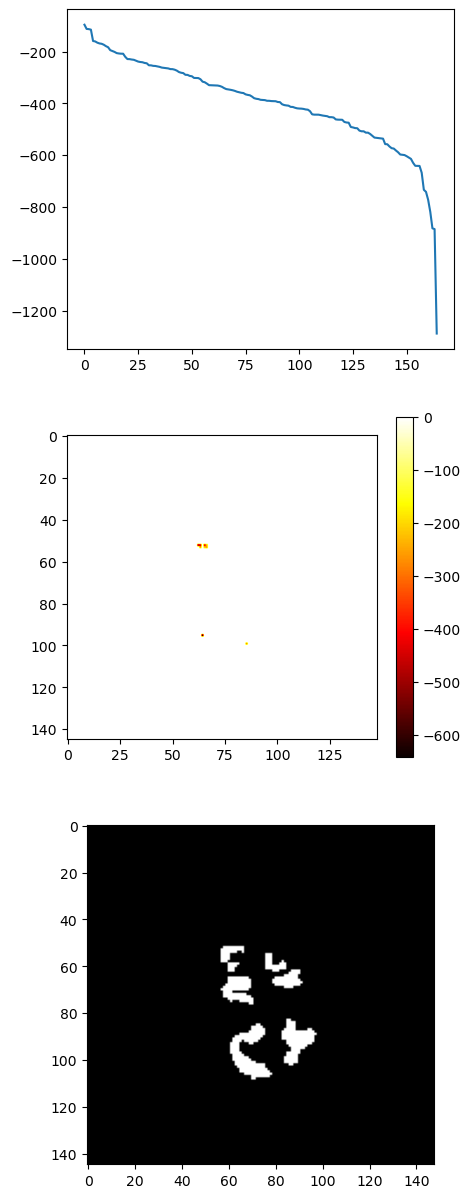

In [268]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a diverging colormap where the 0 value is black
# colors = ["blue", "white", "red"]
# cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
# n_voxels = y_all.shape[1]
n_voxels = y.shape[1]

cv_r2_all = np.zeros((n_voxels, 4))
# for vox in range(len(results['cross_validation_scores'])):
for vox in range(n_voxels):
    for idx in range(3):
        # cv_r2_all[vox,idx] = xyzs_all[vox][0][idx]
        cv_r2_all[vox,idx] = xyzs[vox][0][idx]
    cv_r2_all[vox,3] = results['cross_validation_scores'][vox]




brain = NSP.utils.coords2numpy(cv_r2_all, shape=roi_masks['subj01']['V1_mask'].shape, keep_vals=True)

fig,axes = plt.subplots(3,figsize=(5,15))


cv_sorted = NSP.utils.sort_by_column(cv_r2_all, 3, top_n=n_voxels)
axes[0].plot(cv_sorted[:,3]*100)#[:,3].flatten

# Normalize the data to the range [-0.1, 0.1]
# norm = mcolors.Normalize(vmin=-0.002, vmax=0.002)

# Display the image with the custom colormap and normalization
im = axes[1].imshow(brain[:,16,:]*100, cmap='hot')
axes[2].imshow(roi_masks['subj01']['V2_mask'][:,16,:], cmap='gray')
# Add a colorbar
plt.colorbar(im)

plt.show()


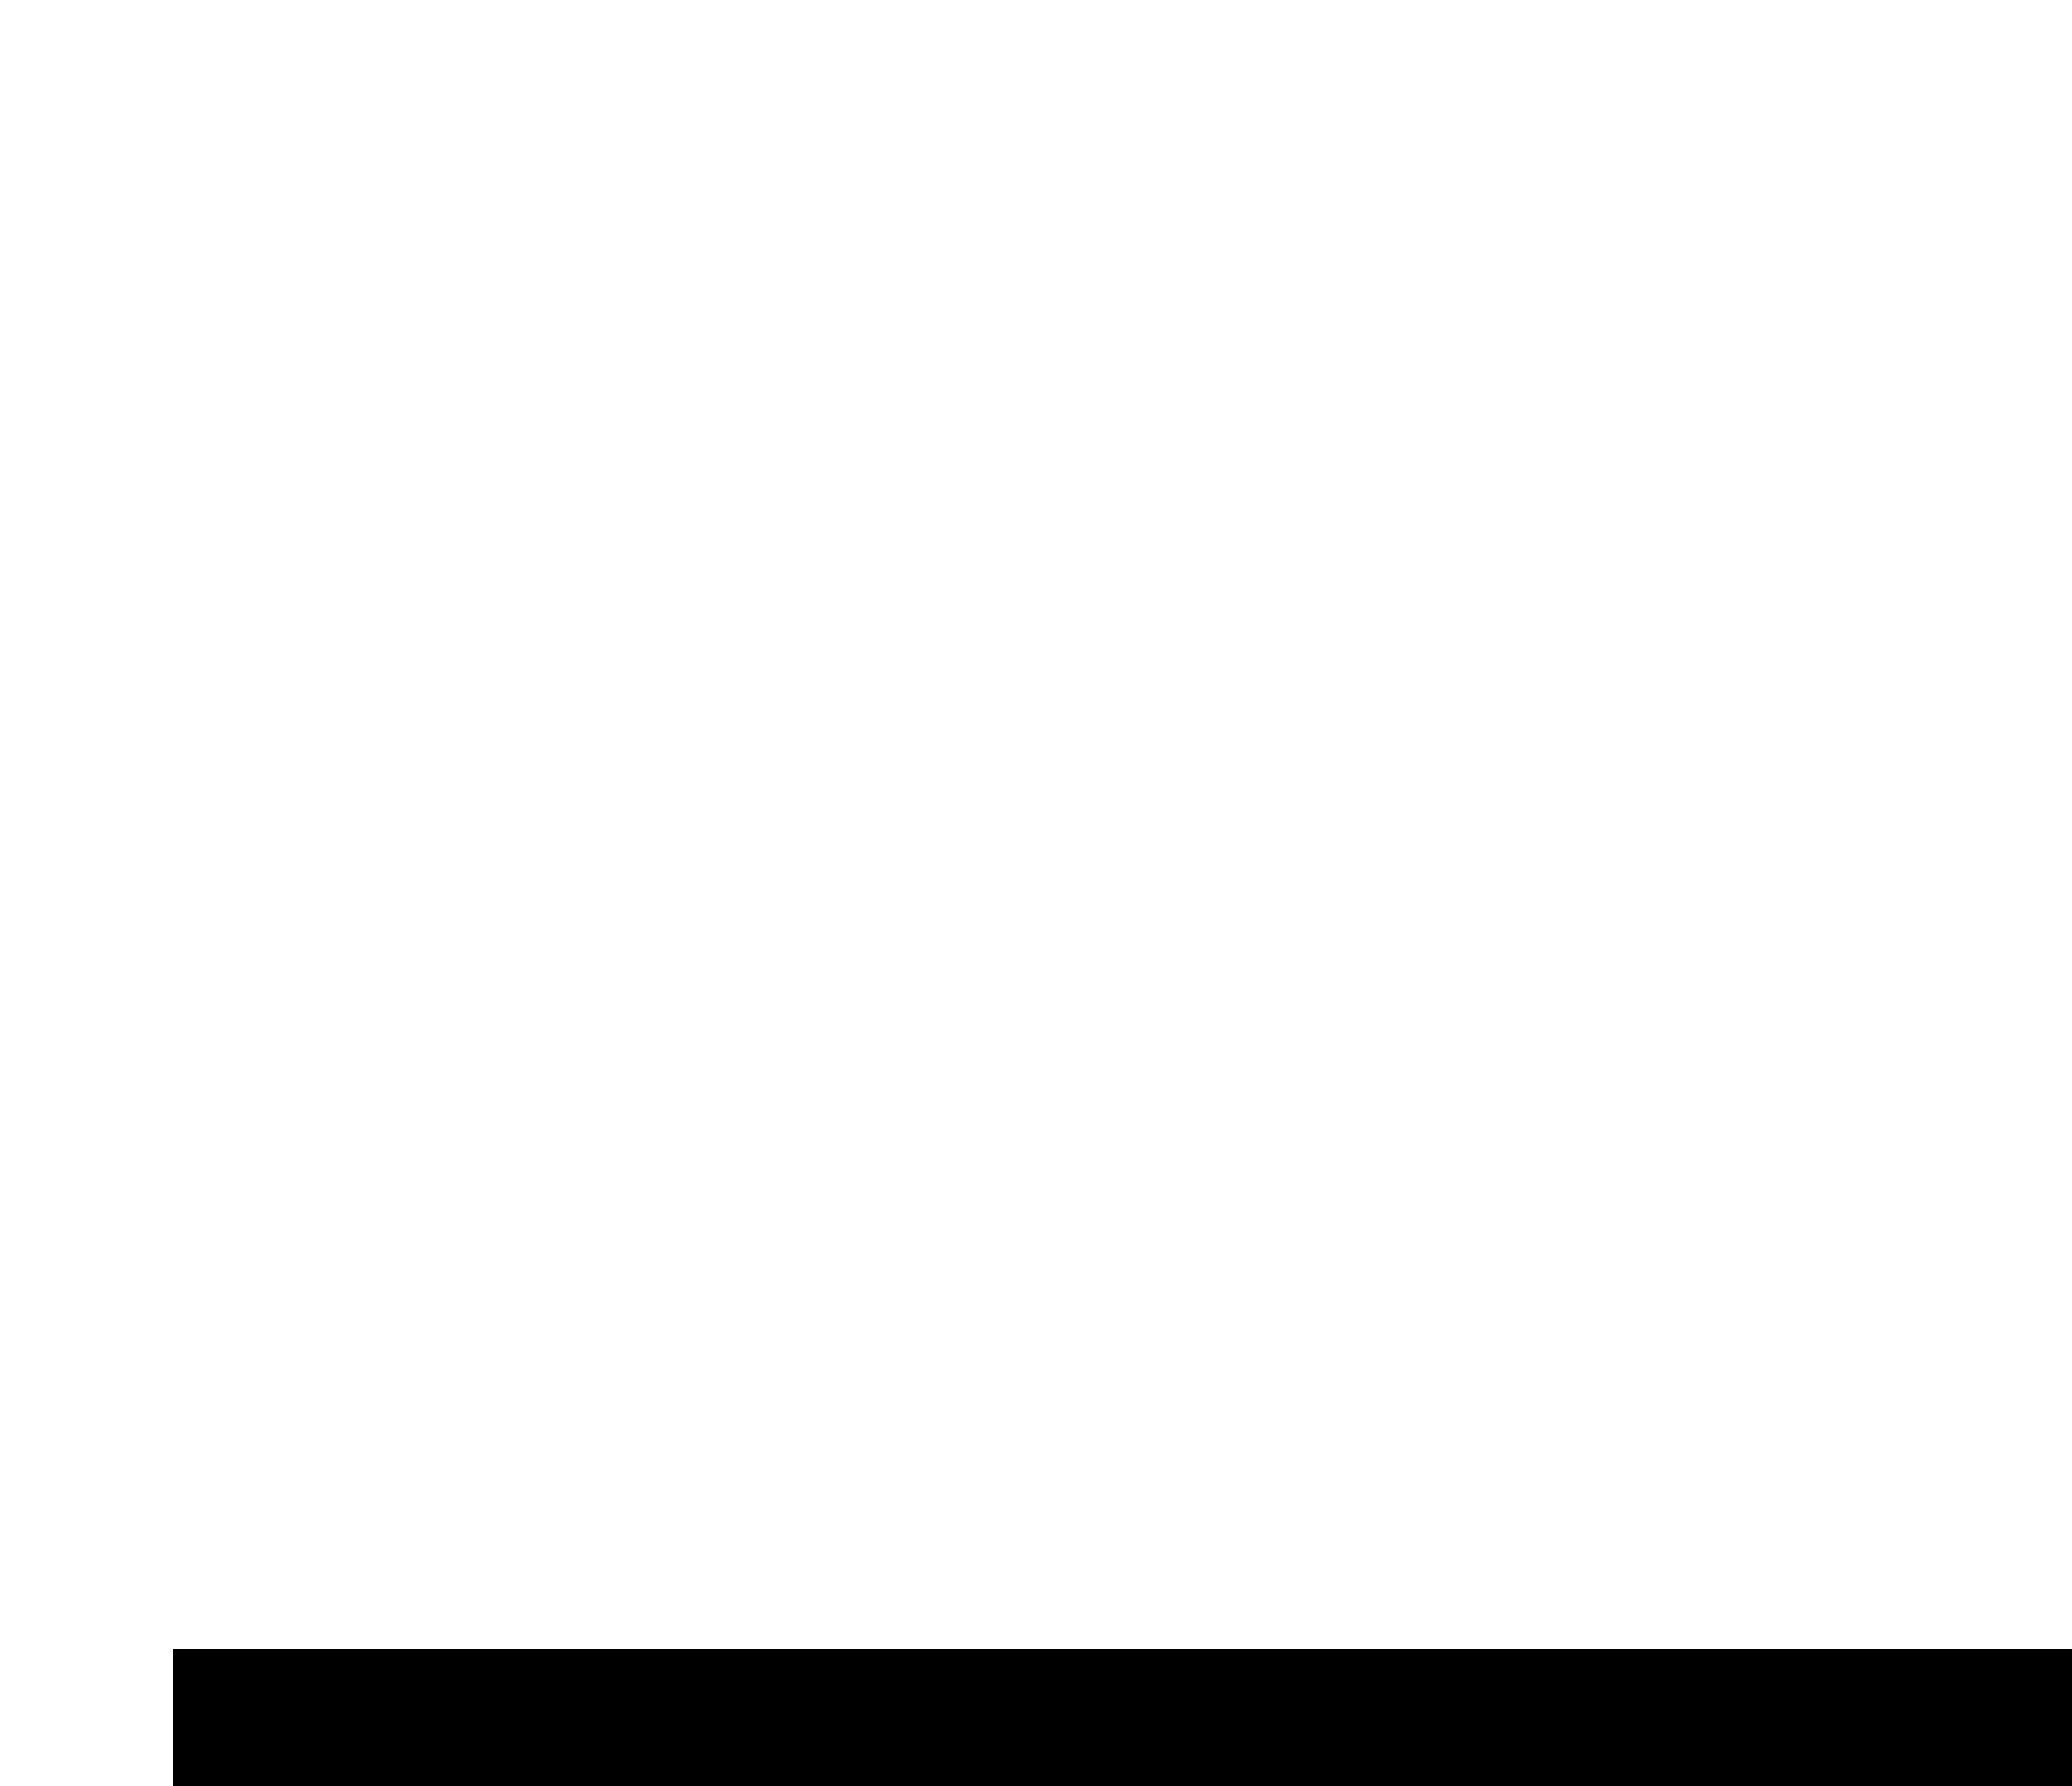
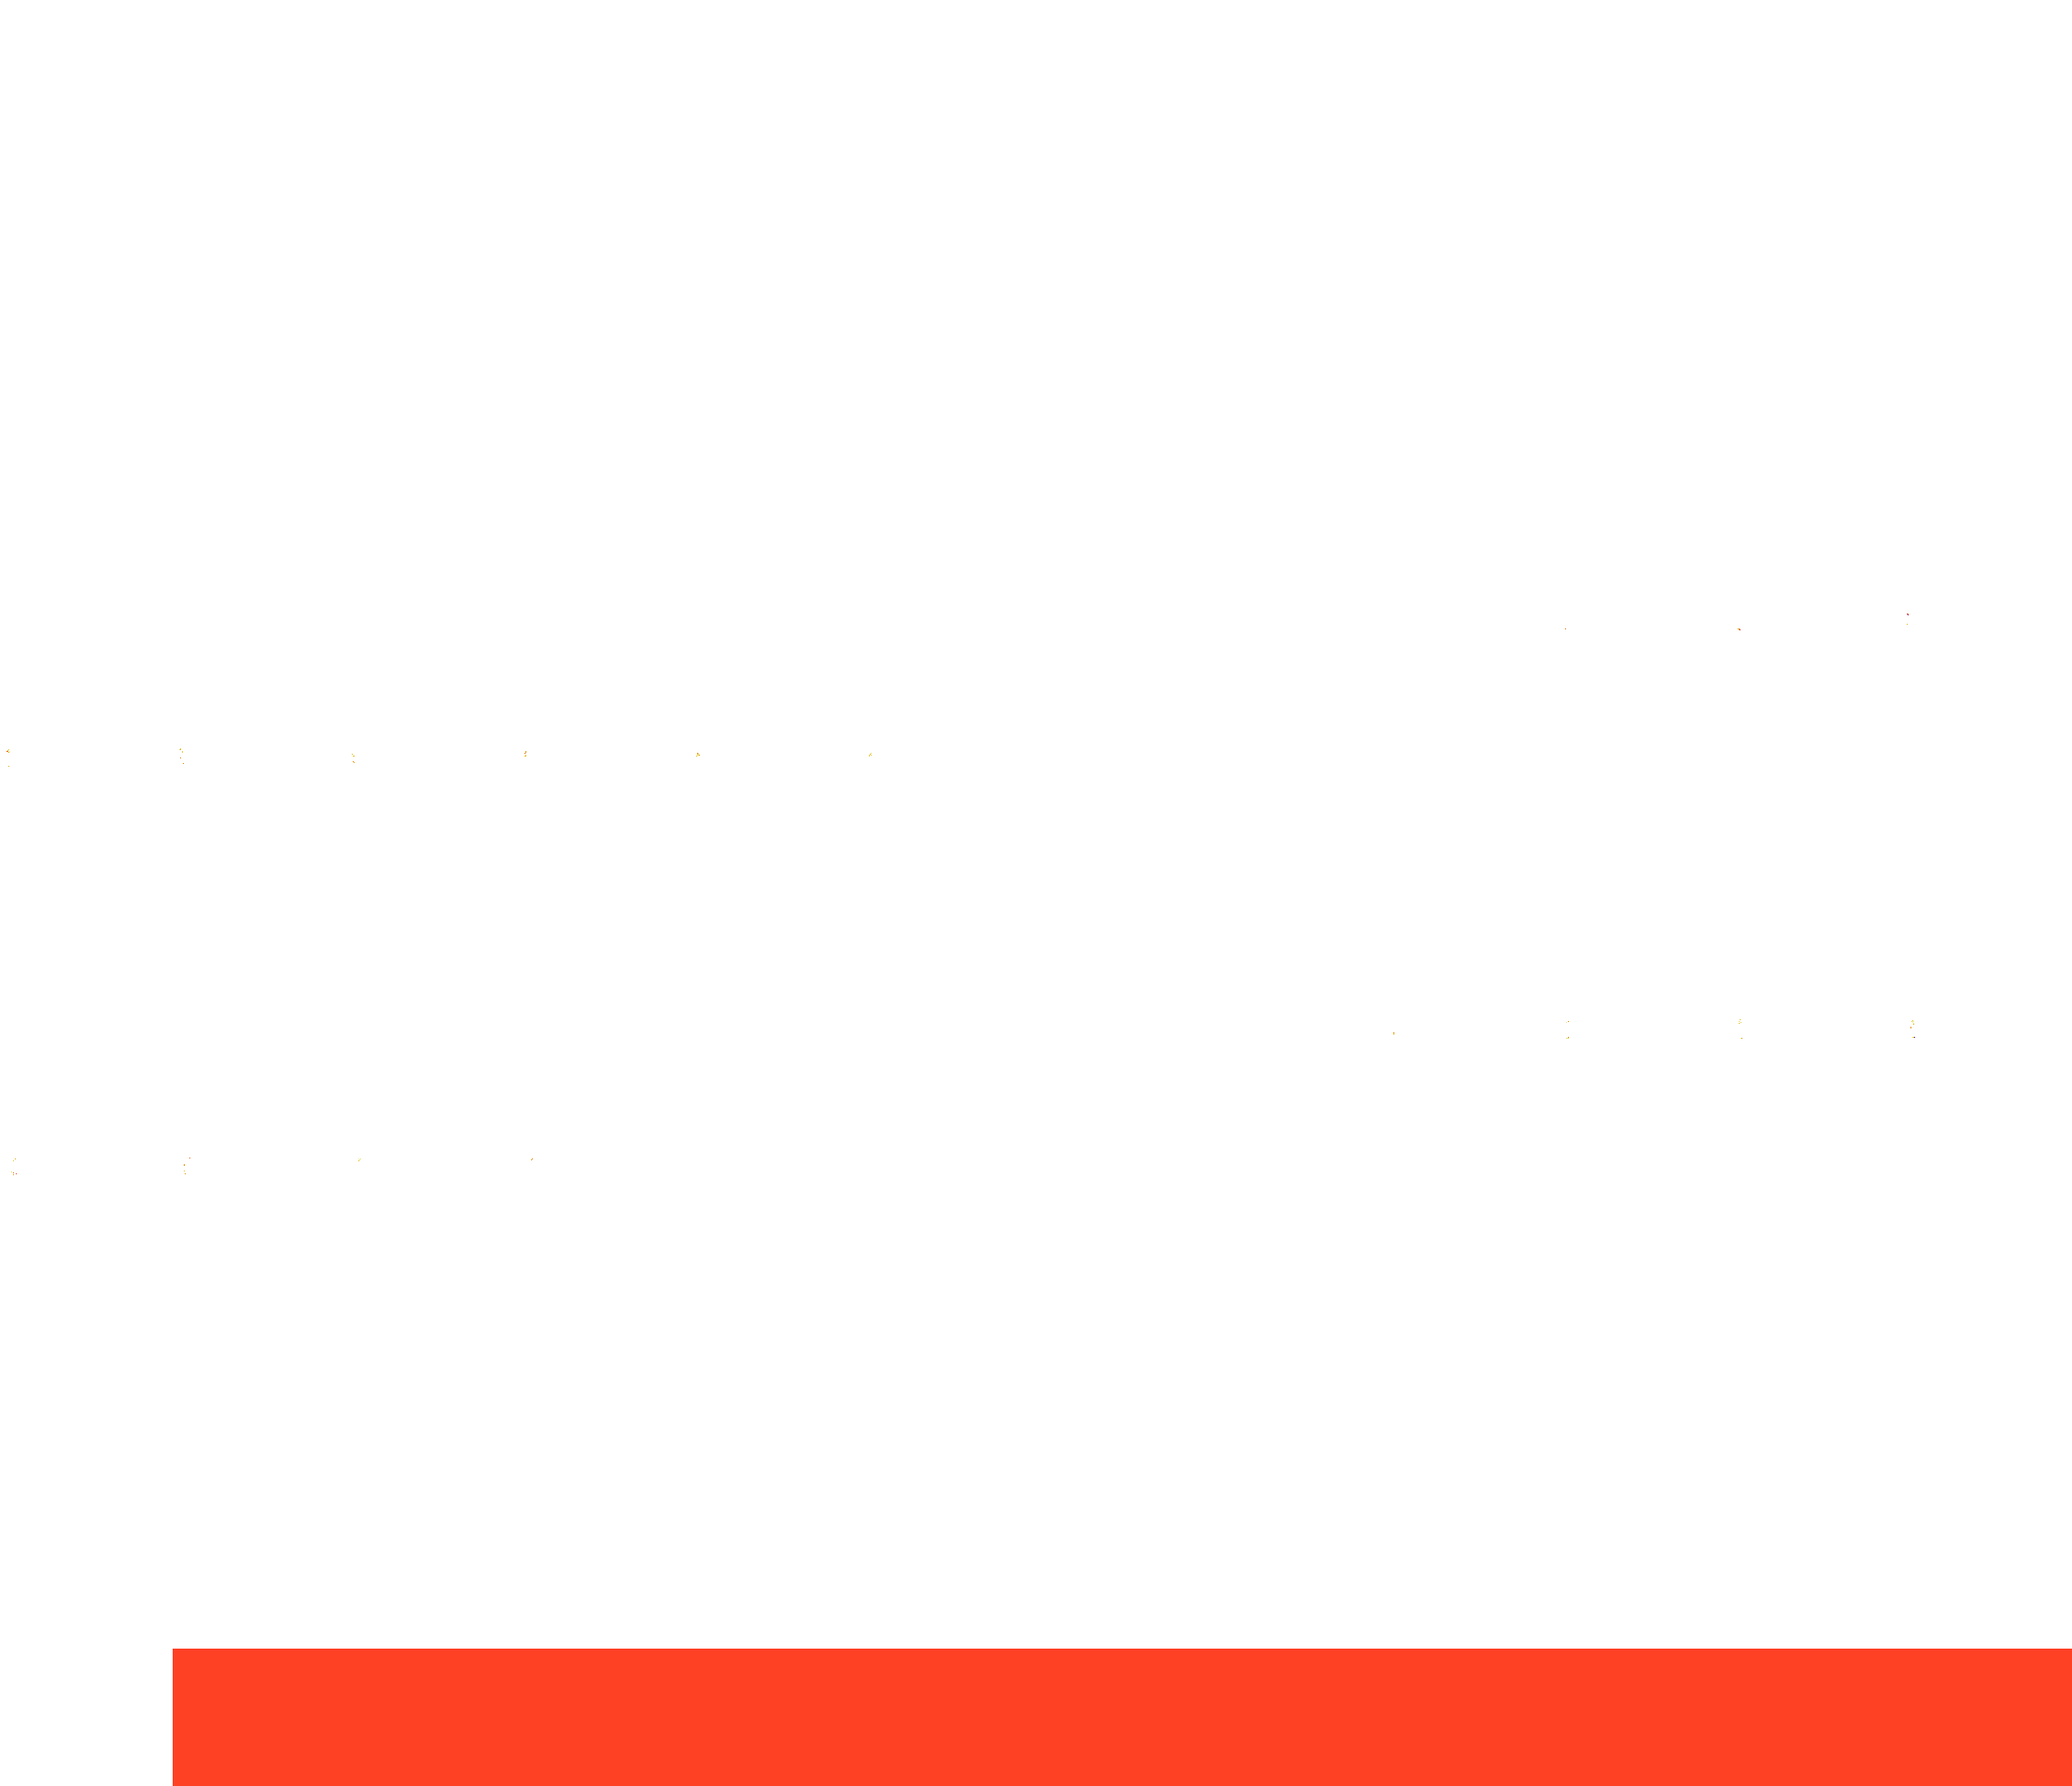

In [59]:
from scipy.special import softmax
anat_sub1_np = NSP.cortex.anat_templates(prf_dict)['subj01'].get_fdata()
# print(anat_maps['subj01'].shape)

anat_sub1_coords = NSP.utils.numpy2coords(anat_sub1_np, keep_vals = True)

anat_sub1_coords[:,3] = softmax(anat_sub1_coords[:,3])

anat_sub1_sm = NSP.utils.coords2numpy(anat_sub1_coords, shape = NSP.cortex.anat_templates(prf_dict)['subj01'].shape, keep_vals = True)

# Convert numpy array back to nibabel image
anat_sub1_sm_nii = nib.Nifti1Image(brain*100, NSP.cortex.anat_templates(prf_dict)['subj01'].affine)

# Now you can use this nibabel image with nilearn's plotting function
# plotting.view_img(anat_sub1_sm_nii, bg_img=None, cmap='binary', symmetric_cmap=False)
plotting.view_img(anat_sub1_sm_nii, bg_img=None, cmap='CMRmap', symmetric_cmap=True)

# plotting.view_img(anat_sub1_sm, bg_img=None, cmap='binary', symmetric_cmap=False)


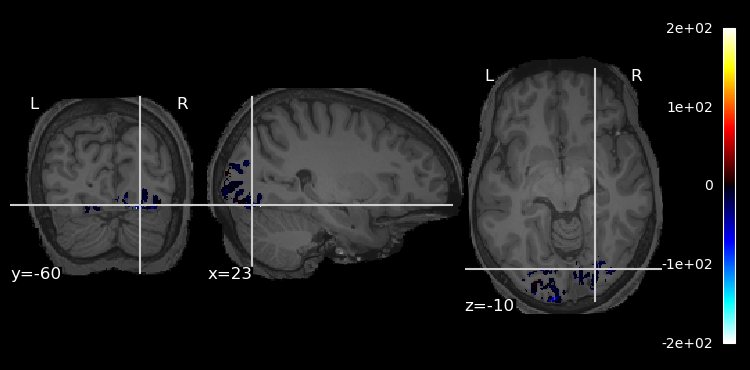

In [208]:
plotting.plot_stat_map(anat_sub1_sm_nii, bg_img=NSP.cortex.anat_templates(prf_dict)['subj01'], display_mode='ortho', colorbar=True)

In [ ]:
# This function creates a numpy array that I can use to transform into a plottable numpy array in the shape of the subjects brain.
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from nilearn import plotting, image
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap


def visualise_betas(hrf_dict = None, subject = 'subj01', n_trials = 10, which_roi = 'V1', n_voxels = 'all', z_voxel:bool = True):
    if which_roi == 'all':
        rois = hrf_dict[subject].keys()
    else: 
        rois = [f'{which_roi}_mask']
    
    for roi in rois:
        if n_voxels == 'all':
            n_voxels = len(hrf_dict[subject][roi])
            
        voxbetas = np.zeros((n_voxels, n_trials + 3))    
        print(voxbetas.shape)
        # Initialize lists to store voxel coordinates and beta values
        voxel_coords = []
        beta_values = []

        for whichvox, voxel in enumerate(list(hrf_dict[subject][roi].keys())[1 : (n_voxels + 1)]): # 1 because the first one is not a voxel but roi_sizes
            betas = hrf_dict[subject][roi][voxel]['hrf_betas'][:n_trials]
            if z_voxel:
                betas = get_zscore(betas, print_ars = False)
            voxel = hrf_dict[subject][roi][voxel]['xyz']
            
            # Append voxel coordinates and beta values to the lists
            voxel_coords.append(voxel)
            beta_values.append(betas)

            voxbetas[whichvox,:3] = voxel
            voxbetas[whichvox,3:] = betas

        
    def _trialbrain(trial_ar=None, which_trial=0, subject = None):
        anat_sub1 = nib.load(f'/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/T1_to_func1mm.nii.gz')

        trial_np = coords2numpy(np.concatenate((voxbeta_df[:,:3], voxbeta_df[:,which_trial:which_trial + 1]), axis=1), shape=prf_dict['subj01']['nsd_dat']['angle']['prf_ar'].shape, keep_vals=True)
        
        trial_nii = nib.Nifti1Image(trial_np, anat_sub1.affine)

        # data = trial_np
        # ref_img = nib.Nifti1Image(np.empty_like(data), affine=np.eye(4))
        # zscored_img = image.new_img_like(ref_img, data)

        # # Define the colors
        # cmap = LinearSegmentedColormap.from_list(
        #     "mycmap", [(0, "black"), (0.5, "blue"), (1, "red")]
        # )
        
        # # Create the TwoSlopeNorm instance with vmin and vmax set during creation
        # norm = TwoSlopeNorm(vcenter=0, vmin=-3, vmax=3)

        # Plot the stat map
        # plotting.plot_stat_map(zscored_img, cmap=cmap, norm=norm, colorbar=True)
        plotting.plot_stat_map(trial_nii, bg_img=anat_sub1, display_mode='ortho', colorbar=True)
        plt.show()

            
    _trialbrain(trial_ar = voxbetas, which_trial = 7, subject = subject) # Doesn't work for a lot of trials, annoying. Fix the colour mapping
                    
                    
    return voxbetas
            
voxbeta_df = visualise_betas(hrf_dict = hrf_dict_tight, subject = 'subj01', n_trials = 30000, which_roi = 'V4', n_voxels = 'all', z_voxel = True)

##### Combine the plotting function below to visualise the R2 nifti I'll make tonight

In [83]:
rel_obj_np.shape

NameError: name 'rel_obj_np' is not defined

In [81]:
NSP.cortex.viscortex_plot(prf_dict = prf_dict, vismask_dict = roi_masks, plot_param = 'nsdR2', subject = 'subj01', upcap = 100, lowcap = 0, inv_colour = False, cmap = 'gist_stern')

interactive(children=(IntSlider(value=144, description='x', max=432, min=-144), IntSlider(value=6, description…

Loading the Model...


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time per image: 0.15640521049499512 seconds


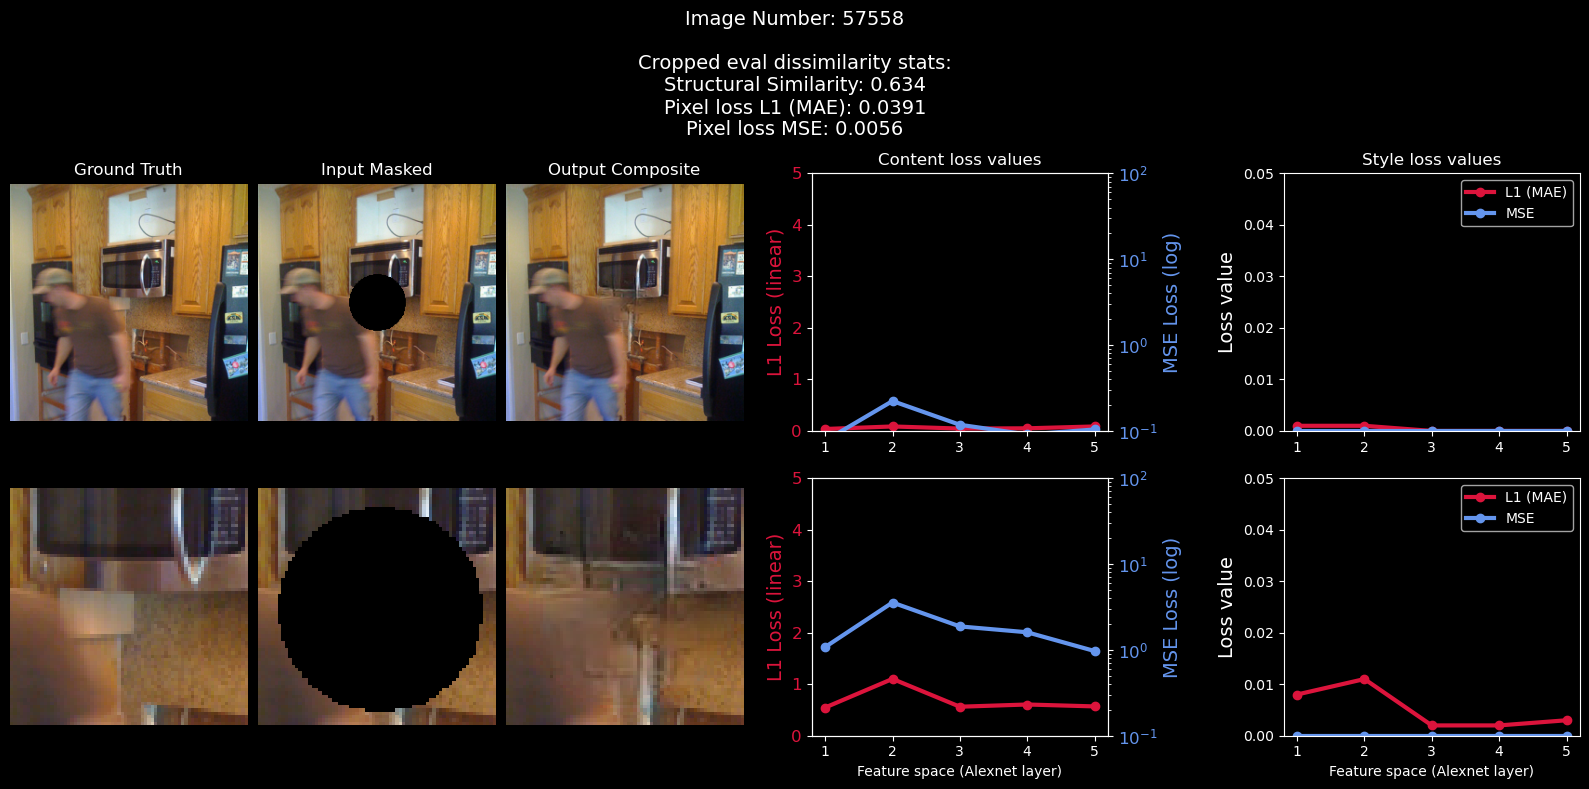

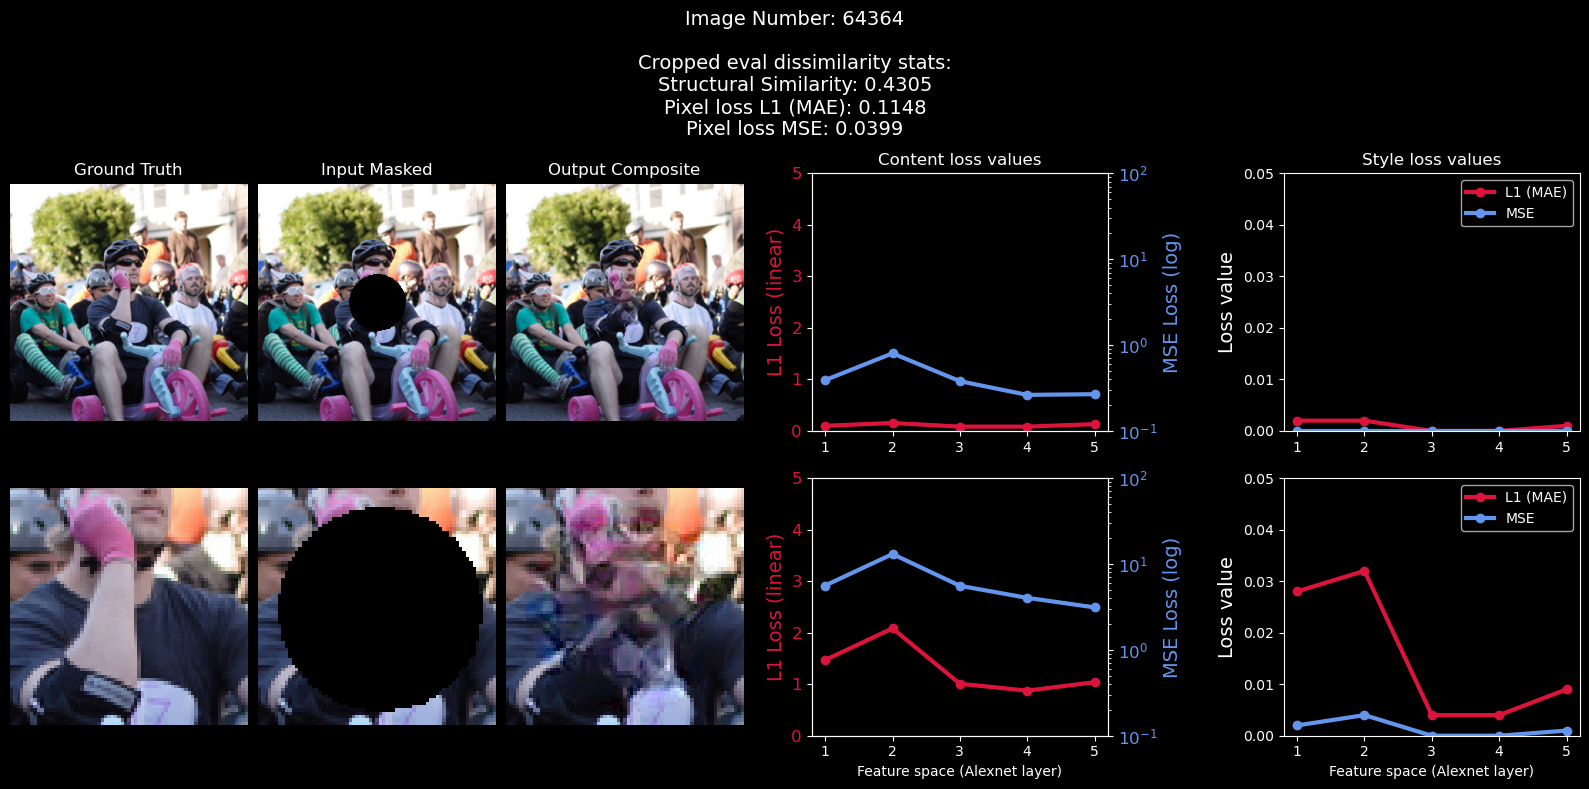

In [13]:
# THESE AREN'T NECESSARY ANYWHERE
R2_dict = NSP.cortex.nsd_R2_dict(roi_masks, glm_type='hrf')
prf_rsq_dict = NSP.cortex.rsquare_selection(prf_dict, 1000, n_subjects=8, dataset='prf')
nsd_rsq_dict = NSP.cortex.rsquare_selection(R2_dict, 1000, n_subjects=8, dataset='nsd')

Subject: subj01, Voxel 1 out of 10 found
Subject: subj01, Voxel 2 out of 10 found
Subject: subj01, Voxel 3 out of 10 found
Subject: subj01, Voxel 4 out of 10 found
Subject: subj01, Voxel 5 out of 10 found
Subject: subj01, Voxel 6 out of 10 found
Subject: subj01, Voxel 7 out of 10 found
Subject: subj01, Voxel 8 out of 10 found
Subject: subj01, Voxel 9 out of 10 found
Subject: subj01, Voxel 10 out of 10 found


Currently 10 prfs found
Subject: subj02, Voxel 1 out of 10 found
Subject: subj02, Voxel 2 out of 10 found
Subject: subj02, Voxel 3 out of 10 found
Subject: subj02, Voxel 4 out of 10 found
Subject: subj02, Voxel 5 out of 10 found
Subject: subj02, Voxel 6 out of 10 found
Subject: subj02, Voxel 7 out of 10 found
Subject: subj02, Voxel 8 out of 10 found
Subject: subj02, Voxel 9 out of 10 found
Subject: subj02, Voxel 10 out of 10 found


Currently 20 prfs found
Subject: subj03, Voxel 1 out of 10 found
Subject: subj03, Voxel 2 out of 10 found
Subject: subj03, Voxel 3 out of 10 found
Sub

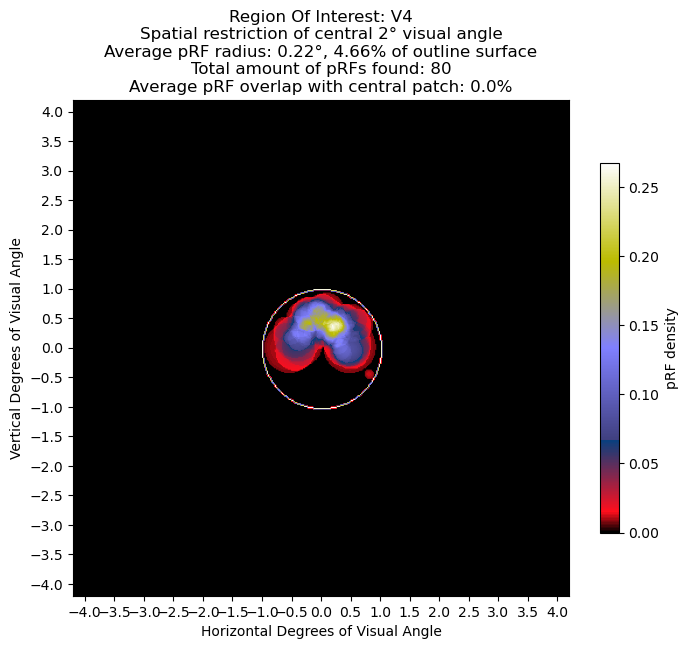

Runtime: 124.022 seconds
There were <built-in function iter> out of 3976 pRFs considered


In [18]:

start = time.time()
# heatmap, iter, end_premat, roi, prf_sizes, avg_surf, total_prfs, prfmask_dict, prf_overlaps
end_premat = NSP.cortex.prf_heatmap(10, binary_masks=roi_masks, prf_proc_dict=prf_dict,
                                                        mask_type='cut_gaussian', cmap='gist_stern', print_prog='y', 
                                                        roi='V4', sigma_min=0, sigma_max = 1, ecc_max = 1, subjects='all', 
                                                        outline_degs = 1, 
                                                        filter_dict = nsd_rsq_dict, ecc_strict = 'y')[2]

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

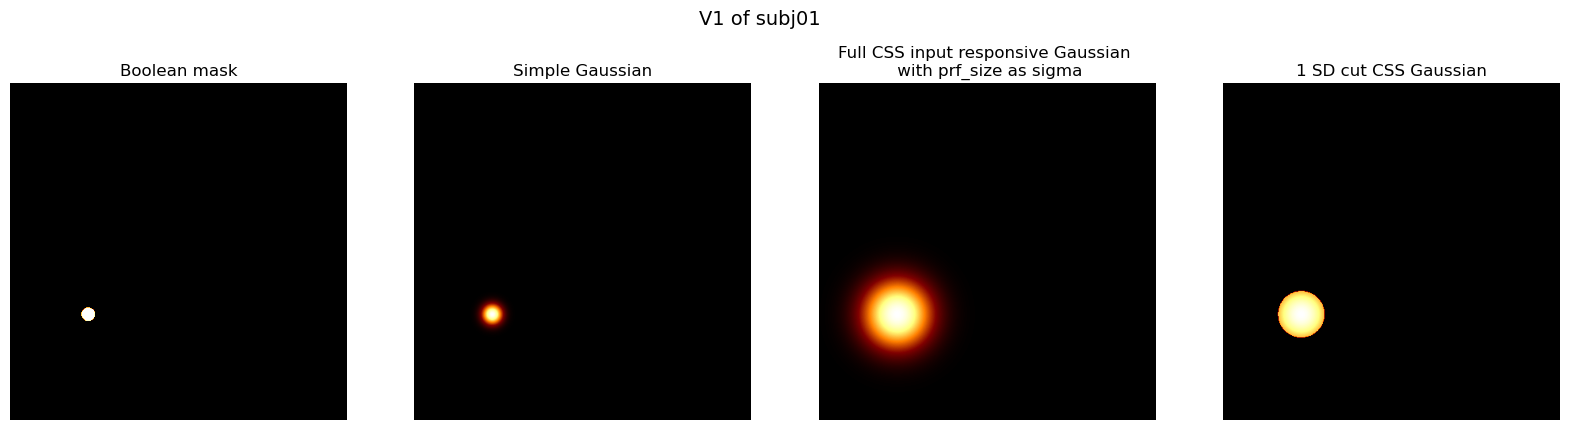

In [65]:
NSP.explore.compare_masks(roi_masks, prf_dict)

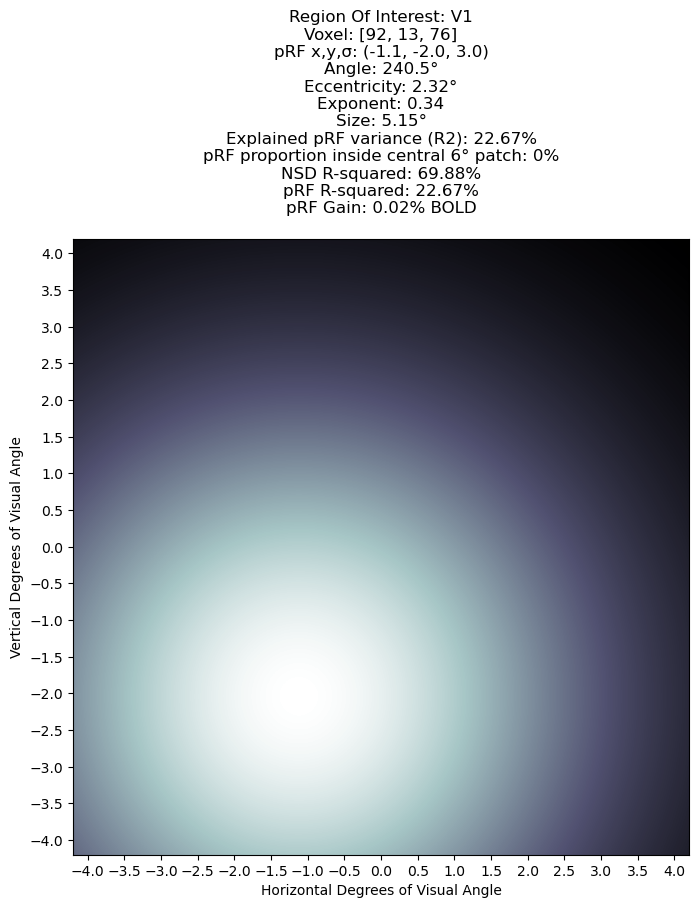

In [47]:
out = NSP.cortex.get_mask(dim = 425, subject = 'subj01', binary_masks = roi_masks, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V1',
                                        plot = 'y', excl_reason = 'n', sigma_min=2.9, sigma_max = 3,
                                        ecc_min = 2, ecc_max = 3,
                                        angle_min = 0, angle_max = 360)

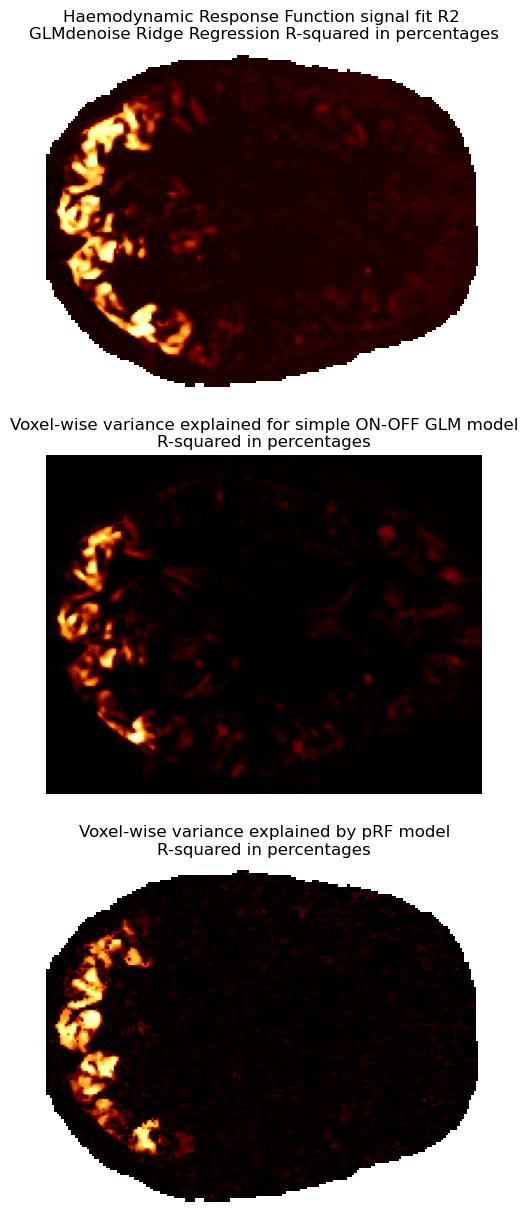

In [44]:
NSP.explore.compare_NSD_R2s(roi_masks, prf_dict, 'subj01', 76)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# AlexNet(
#   (features): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#     (1): ReLU(inplace=True)
#     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (4): ReLU(inplace=True)
#     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (7): ReLU(inplace=True)
#     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (9): ReLU(inplace=True)
#     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (11): ReLU(inplace=True)
#     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)
#   )
# )